# Import

In [1]:
import numpy as np
from scipy.stats import norm
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import statistics
from scipy import signal, stats
from scipy.optimize import curve_fit
import scipy.fftpack
from scipy import interpolate
from cycler import cycler
from inspect import signature

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
#%matplotlib notebook

In [3]:
def get_plot_data(ax, filename) :
    header = ax.get_xlabel()
    data = ax.lines[0].get_xdata()
    for line in ax.lines :
        header = header + ' ' + line.get_label() 
        data = np.vstack((data,line.get_ydata()))
    data = np.transpose(data)
    np.savetxt(filename+'.dat', data, fmt='%.18e', delimiter=' ', newline='\n', header=header, footer='', comments='# ', encoding=None)
    return ('saved to ' + filename) 

In [4]:
def get_plot_data_blocks(ax, filename) :
    for line in ax.lines :
        header = ax.get_xlabel() + ' ' + line.get_label() 
        data = np.vstack((line.get_xdata(),line.get_ydata()))
        data = np.transpose(data)
        np.savetxt(filename+'_'+line.get_label()+'.dat', data, fmt='%.18e', delimiter=' ', newline='\n', header=header, footer='', comments='# ', encoding=None)
    return ('saved to ' + filename) 

# Data structure

In [5]:
data_set = [{'Rl': 40, 'N': 64, 'filter_cut_off_k': 10, 'run_windows' : [1008]},
        {'Rl': 60, 'N': 128, 'filter_cut_off_k': 12, 'run_windows' : [664]}, 
        {'Rl': 90, 'N': 256, 'filter_cut_off_k': 25, 'run_windows' : [312, 312]},
        {'Rl': 160, 'N': 512, 'filter_cut_off_k': 40, 'run_windows' : [57, 57, 57, 29, 58, 58]},
        {'Rl': 250, 'N': 1024, 'filter_cut_off_k': 80, 'run_windows' : [5, 5, 5, 1, 4, 4, 2]}]

# Read files

In [6]:
#reading routine
def read_data_file(common_folder, folder_in, Rl, N, file_type, spec_type, spec_component, run_files) :
    nb_of_runs = len(run_files)
    for run_index in list(range(nb_of_runs)) :
        folder = common_folder + "rl" + str(Rl) + "_N" + str(N) + "/" + folder_in + "run" + "%01d" % (run_index+1) + "/"
        if (run_files[run_index] < 1000) :
            file = folder + file_type + "_" + spec_type + "_C" + spec_component + "_wi=" + "%03d" % run_files[run_index] + ".table"
        else : 
            file = folder + file_type + "_" + spec_type + "_C" + spec_component + "_wi=" + "%06d" % run_files[run_index] + ".table"
        file_data = []
        print('reading file: ' + file)
        averaging_weight = (run_files[run_index]+1)/(sum(run_files)+nb_of_runs)
        for line in open(file) :
            temp_array_line = []
            if line[0] == '#' :          #skip commented lines
                continue
            else :
                temp_array_line=list(map(float, line.split( )))
                temp_array_line = [t * averaging_weight for t in temp_array_line]
                file_data.append(temp_array_line)  
        if (run_index == 0) : 
            accumulated_data = file_data.copy()
        else : 
            accumulated_data = list(map(lambda l1, l2: [sum(x) for x in zip(l1, l2)], accumulated_data, file_data))
    k = np.array(accumulated_data[0])
    nb_of_modes = np.array(accumulated_data[1])
    average_data = np.ndarray(shape=(len(accumulated_data)-2, k.shape[0]+1), dtype=float)
    for i in list(range(average_data.shape[0])) : 
        average_data[i, :] = np.array(accumulated_data[i+2])
    t = average_data[:,0]
    numpy_file_table = np.array(average_data[:,1:])
    return [k, nb_of_modes, t, numpy_file_table]

In [7]:
common_folder = "/home/gorbunov8a/data/filtered_advection/"
spec_type = "lin"
spec_component = "avg"

In [8]:
# read data files
for simu in data_set : 
    folder_in = "filter" + "%02d" % simu['filter_cut_off_k'] + "/"
    Rl = simu['Rl']; N = simu['N']; run_windows = simu['run_windows']
    simu.update(t_total={'legend': r'$\hat{T}^{total}$'}, t_sss={'legend': r'$\hat{T}^{SSS}$'}, t_sls={'legend': r'$\hat{T}^{SLS}$'}, t_sl={'legend': r'$\hat{T}^{SL}$'}, corr={'legend' : r'$C^{(2)}$'})
    [k, nb_of_modes, t, t_total] = read_data_file(common_folder, folder_in, Rl, N, "total_transfer_corr", spec_type, spec_component, run_windows) # total_t - all energy transgers to the shell k
    [k, nb_of_modes, t, t_ss] = read_data_file(common_folder, folder_in, Rl, N, "t_ss", spec_type, spec_component, run_windows) # t_ss - energy transfers between small scales
    [k, nb_of_modes, t, t_sss] = read_data_file(common_folder, folder_in, Rl, N, "t_sss", spec_type, spec_component, run_windows) # t_sss - only transfers with all three small modes
    [k, nb_of_modes, t_corr, two_point_corr] = read_data_file(common_folder, folder_in, Rl, N, "two_point_corr", spec_type, "avg", run_windows)
    t_sls = t_ss - t_sss # t_sls - energy transfer between small scales with a large scale mediator mode
    t_sl = t_total - t_ss # t_sl = t_ssl + t_sll - non-local transfer to small scales from large scales 
    simu.update({'k': k, 'nb_of_modes' : nb_of_modes})
    simu['t_total'].update({'data': t_total, 'time' : t})
    simu['t_sss'].update({'data': t_sss, 'time' : t})
    simu['t_sls'].update({'data': t_sls, 'time' : t})
    simu['t_sl'].update({'data': t_sl, 'time' : t})
    simu['corr'].update({'data': two_point_corr, 'time' : t_corr})
    del k, nb_of_modes, t, t_total, t_ss, t_sss, t_corr, two_point_corr, t_sls, t_sl

reading file: /home/gorbunov8a/data/filtered_advection/rl40_N64/filter10/run1/total_transfer_corr_lin_Cavg_wi=001008.table
reading file: /home/gorbunov8a/data/filtered_advection/rl40_N64/filter10/run1/t_ss_lin_Cavg_wi=001008.table
reading file: /home/gorbunov8a/data/filtered_advection/rl40_N64/filter10/run1/t_sss_lin_Cavg_wi=001008.table
reading file: /home/gorbunov8a/data/filtered_advection/rl40_N64/filter10/run1/two_point_corr_lin_Cavg_wi=001008.table
reading file: /home/gorbunov8a/data/filtered_advection/rl60_N128/filter12/run1/total_transfer_corr_lin_Cavg_wi=664.table
reading file: /home/gorbunov8a/data/filtered_advection/rl60_N128/filter12/run1/t_ss_lin_Cavg_wi=664.table
reading file: /home/gorbunov8a/data/filtered_advection/rl60_N128/filter12/run1/t_sss_lin_Cavg_wi=664.table
reading file: /home/gorbunov8a/data/filtered_advection/rl60_N128/filter12/run1/two_point_corr_lin_Cavg_wi=664.table
reading file: /home/gorbunov8a/data/filtered_advection/rl90_N256/filter25/run1/total_transfe

In [9]:
# # read the variation files
# spec_type = "variance_lin"
# for simu in data_set : 
#     folder_in = "filter" + "%02d" % simu['filter_cut_off_k'] + "/"
#     Rl = simu['Rl']; N = simu['N']; run_windows = simu['run_windows']
#     [k, nb_of_modes, t, t_total] = read_data_file(common_folder, folder_in, Rl, N, "total_transfer_corr", spec_type, spec_component, run_windows) # total_t - all energy transgers to the shell k
#     [k, nb_of_modes, t, t_ss] = read_data_file(common_folder, folder_in, Rl, N, "t_ss", spec_type, spec_component, run_windows) # t_ss - energy transfers between small scales
#     [k, nb_of_modes, t, t_sss] = read_data_file(common_folder, folder_in, Rl, N, "t_sss", spec_type, spec_component, run_windows) # t_sss - only transfers with all three small modes
#     [k, nb_of_modes, t_corr, two_point_corr] = read_data_file(common_folder, folder_in, Rl, N, "two_point_corr", spec_type, "avg", run_windows)
#     t_sls = t_ss - t_sss # t_sls - energy transfer between small scales with a large scale mediator mode
#     t_sl = t_total - t_ss # t_sl = t_ssl + t_sll - non-local transfer to small scales from large scales 
#     simu['t_total'].update({'data_var': t_total})
#     simu['t_sss'].update({'data_var': t_sss})
#     simu['t_sls'].update({'data_var': np.full_like(t_sls, 1.0)})
#     simu['t_sl'].update({'data_var': np.full_like(t_sl, 1.0)})
#     simu['corr'].update({'data_var': two_point_corr})
#     del k, nb_of_modes, t, t_total, t_ss, t_sss, t_corr, two_point_corr, t_sls, t_sl

# Parameters

In [10]:
nu = 0.0001
pi = np.pi
for simu in data_set : 
    if (simu['Rl'] == 40) :
        simu['lambda'] = 0.57; simu['eta'] = 0.511e-1; simu['dissip_rate'] = 0.145e-6; 
        simu['ekin'] = 5.34e-5;
    if (simu['Rl'] == 60) :
        simu['lambda'] = 0.378; simu['eta'] = 0.0254807; simu['dissip_rate'] = 0.2244E-5
        simu['ekin'] = 3.53e-4;  
    if (simu['Rl'] == 90) :
        simu['lambda'] = 0.2352; simu['eta'] = 0.126e-1; simu['dissip_rate'] = 0.3919e-4;
        simu['ekin'] = 2.25e-3; 
    if (simu['Rl'] == 160) :
        simu['lambda'] = 0.155; simu['eta'] = 0.006436; simu['dissip_rate'] = 0.6E-3; 
        simu['ekin'] = 1.59e-2; 
    if (simu['Rl'] == 250) :
        simu['lambda'] = 0.1; simu['eta'] = 0.32e-2; simu['dissip_rate'] = 0.94e-2;
        simu['ekin'] = 0.1013; 
    #simu['t0']=simu['dissip_rate']**(-1.0/3.0)*simu['L']**(2.0/3.0) #large scale eddy-turnover time characteristic scale 
    simu['urms'] = np.sqrt(2.0/3.0*simu['ekin']); simu['L'] = (np.sqrt(2.0/3.0*simu['ekin'])**3)/simu['dissip_rate'] 
    simu['t0'] = simu['L']/simu['urms']
    simu['k_norm'] = 1.0/simu['L']
    simu['ikf'] = int(np.searchsorted(simu['k'], simu['filter_cut_off_k']))
    simu['ik2f'] = int(np.searchsorted(simu['k'], 2.0*simu['filter_cut_off_k']))
    simu['spher_coef'] = 4.0*np.pi*simu['k']**2.0/simu['nb_of_modes']
    #find wavenumber corresponding to the dealiasing cut-off
    shift_init=20
    simu['ik_max'] = shift_init + (np.argwhere(simu['spher_coef'][shift_init::]>1.022)[0])[0]

In [11]:
for simu in data_set : 
    print(simu['t0'])

245.51724137931032
104.87225193107545
38.275070170961975
17.666666666666664
7.1843971631205665


# Plot appearance

In [12]:
nb_of_curves = 6

for simu in data_set : 
    simu['indices_of_k_to_plot'] = np.int_(np.linspace(simu['ikf'], simu['ik_max'], nb_of_curves))
    #simu['indices_of_k_to_plot2'] = np.int_(np.linspace(7, simu['ik_max']-15, nb_of_curves))
    #simu['indices_of_k_to_plot2'] = np.concatenate((np.array(np.searchsorted(simu['k']*simu['eta'], np.linspace(0.05, 0.18, 3)),dtype=int), np.array(np.searchsorted(simu['k']*simu['eta'], np.linspace(0.2, 1.4, 3)),dtype=int)))
    simu['indices_of_k_to_plot2'] = np.array(np.searchsorted(simu['k']*simu['eta'], np.linspace(0.14, 1.4, 6)),dtype=int)
    simu['indices_of_k_to_plot3'] = np.int_(np.linspace(simu['ikf'], simu['ik_max'], 10))
    simu['indices_of_k_to_plot4'] = np.array(np.searchsorted(simu['k']*simu['eta'], np.linspace(0.1, 0.2, 8)),dtype=int)
    # legends : 
    simu['legend'] = r"$R_{\lambda}=$" + str(simu['Rl']) + r"$, N = $" + str(simu['N'])
    simu['legend_short'] = r"$R_{\lambda}=$" + str(simu['Rl'])
    # COLORS vs Rl
    if (simu['Rl'] == 60) : 
        simu.update({'color': 'blue'})
    elif (simu['Rl'] == 90) : 
        simu.update({'color': 'orange'})
    elif (simu['Rl'] == 160) : 
        simu.update({'color': 'green'})  
    elif (simu['Rl'] == 250) : 
        simu.update({'color': 'red'})  

In [13]:
plt.rc('axes', labelsize=16)  
plt.rc('axes', titlesize=16)  
plt.rc('legend', fontsize=11)  

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf','#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
linestyles = [(0, (5, 10)), '-', '--', ':', (0, (3, 5, 1, 5, 1, 5)), '-.']
default_cycler = cycler(cycler(linestyle=['-', '--', ':', '-.'])*cycler(color=colors))
plt.rc('axes', prop_cycle=default_cycler)

 # Rearrange spectra in log scale

In [14]:
log_scale_base = 1.15

In [15]:
def logscale_spec(k, nb_of_modes, spec, base, normalized) :
    max_exp = np.int(np.log(np.max(k))/np.log(base))+2
    new_k_segments = np.power(base,np.arange(max_exp))
    new_k = np.zeros(len(new_k_segments)-1)
    new_nb_of_modes = np.zeros(len(new_k_segments)-1)
    new_spec = np.zeros(len(new_k_segments)-1)
    counter_cells_to_merge = np.zeros(len(new_k_segments)-1)
    for i in range(len(new_k_segments)-1) :
        for ik in list(range(len(k))) :
            if ((k[ik] > new_k_segments[i]) & (k[ik] < new_k_segments[i+1])) :
                counter_cells_to_merge[i] = counter_cells_to_merge[i] + 1
                new_k[i] = new_k[i] + k[ik]
                new_nb_of_modes[i] = new_nb_of_modes[i] + nb_of_modes[ik]
                if (normalized == 0) :
                    new_spec[i] = new_spec[i] + spec[ik]
                elif (normalized == 1) :
                    new_spec[i] = new_spec[i] + nb_of_modes[ik]*spec[ik]
    new_k = new_k/counter_cells_to_merge
    if (normalized == 1) : new_spec = new_spec/new_nb_of_modes
    return[new_k, new_nb_of_modes, new_spec]

# Spatial compensated spectrum from C_2(t=0,k)


/tmp/ipykernel_22998/18894126.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  max_exp = np.int(np.log(np.max(k))/np.log(base))+2
/tmp/ipykernel_22998/18894126.py:18: RuntimeWarning: invalid value encountered in true_divide
  new_k = new_k/counter_cells_to_merge
/tmp/ipykernel_22998/18894126.py:19: RuntimeWarning: invalid value encountered in true_divide
  if (normalized == 1) : new_spec = new_spec/new_nb_of_modes
/tmp/ipykernel_22998/18894126.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warni

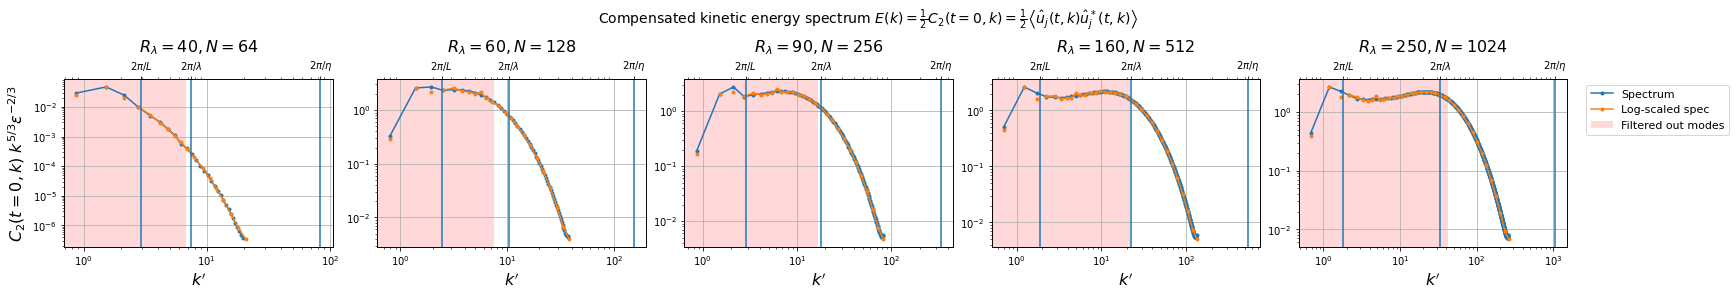

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=len(data_set), constrained_layout=True,figsize=(4*len(data_set)+4,4))
fig.suptitle(r'Compensated kinetic energy spectrum $E(k) = \frac{1}{2} C_2(t=0, k) = \frac{1}{2} \left<\hat{u}_j(t,k) \hat{u}_j^* (t,k) \right>$', size=14) 
for i in list(range(len(data_set))) :
    simu = data_set[i]
    simu['kinetic_energy'] = 0.5*simu['corr']['data'][0,::]
    simu['total_kinetic_energy'] = np.trapz(simu['kinetic_energy'], x=simu['k'])
    #simu['urms'] = np.sqrt(2.0/3.0*simu['total_kinetic_energy'])
    #simu['L'] = 2.0*np.pi*np.trapz(simu['k']**(-1)*simu['kinetic_energy'], x=simu['k'])/simu['total_kinetic_energy']
    #simu['t0'] = simu['L']/simu['urms']
    #simu['k_norm'] = 1/(2.0*np.pi/simu['L']) # integral scale as non-dimensionalisation factor
    simu['spatial_scales'] = np.array([simu['L'], simu['lambda'], simu['eta']])
    
    indices = slice(0,simu['ik_max'])
    ax[i].plot(simu['k'][indices]*simu['k_norm'], simu['kinetic_energy'][indices]*simu['k'][indices]**(5.0/3.0)*simu['dissip_rate']**(-2.0/3.0)*simu['spher_coef'][indices], '.-', label='Spectrum')
    [simu['k_log'], simu['nb_of_modes_log'], simu['spec_log']] = logscale_spec(simu['k'], simu['nb_of_modes'], simu['kinetic_energy'], log_scale_base, 1)
    ax[i].plot(simu['k_log']*simu['k_norm'],simu['spec_log']*simu['k_log']**(5.0/3.0)*simu['dissip_rate']**(-2.0/3.0), '.-', label='Log-scaled spec')
    
    ax[i].set(xscale='log',yscale='log',xlabel=r'$k^\prime$', title=simu['legend']); ax[i].grid()
    if (i == 0) : ax[i].set(ylabel=r'$C_2(t=0,k) \ k^{5/3} \epsilon^{-2/3}$')
    # show the range of the filtered out wavenumbers
    ax[i].axvspan(0, simu['filter_cut_off_k']*simu['k_norm'], facecolor='red', alpha=0.15, label='Filtered out modes')
    # plot spatial scales
    vertical_lines = 2.0*np.pi/simu['spatial_scales']*simu['k_norm']
    for line in vertical_lines : ax[i].axvline(x=line)     
    ax2 = ax[i].twiny(); ax2.set(xscale=ax[i].get_xscale(), yscale=ax[i].get_yscale(), xlim = ax[i].get_xlim())
    ax2.set_xticks(vertical_lines); ax2.set_xticklabels([r'$2\pi/L$', r'$2\pi/\lambda$', r'$2\pi/\eta$'])
    if (i == len(data_set)-1) : lgd = ax[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Dissipation spectrum

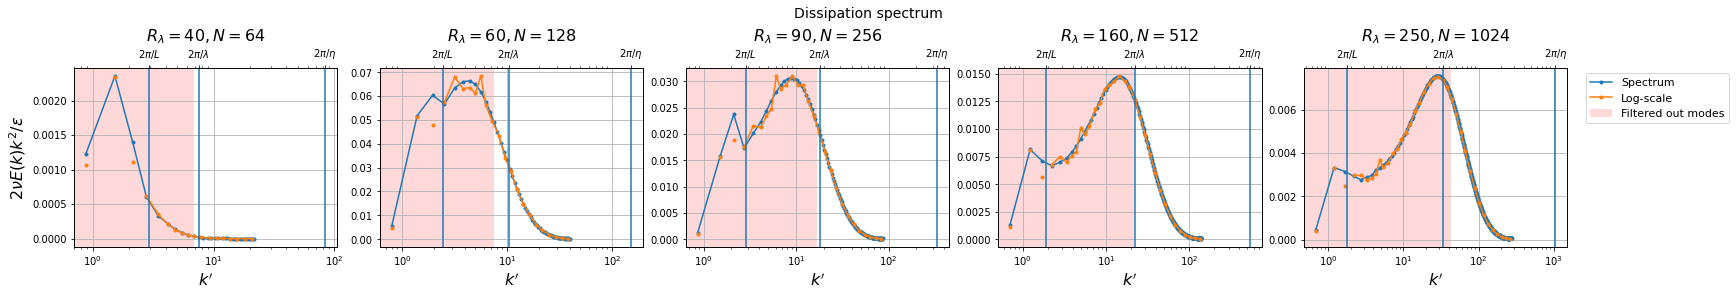

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=len(data_set), constrained_layout=True,figsize=(4*len(data_set)+4,4))
fig.suptitle(r'Dissipation spectrum', size=14) 
for i in list(range(len(data_set))) :
    simu = data_set[i]
    simu['dissipation_spec'] = 2.0*nu*simu['kinetic_energy']*simu['k']**(2.0)
    simu['total_dissipation'] = np.trapz(simu['dissipation_spec'], x=simu['k'])
    norm_coef = 1.0/ simu['dissip_rate']
    ax[i].plot(simu['k']*simu['k_norm'], simu['dissipation_spec']*simu['spher_coef']*norm_coef, '.-', label='Spectrum')
    ax[i].plot(simu['k_log']*simu['k_norm'], 2.0*nu*simu['spec_log']*simu['k_log']**(2.0)*norm_coef, '.-', label='Log-scale')
    ax[i].set(xscale='log',yscale='linear',xlabel=r'$k^\prime$', title=simu['legend']); ax[i].grid()
    if (i == 0) : ax[i].set(ylabel=r'$2 \nu E(k) k^2 / \epsilon$')
    # show the range of the filtered out wavenumbers
    ax[i].axvspan(0, simu['filter_cut_off_k']*simu['k_norm'], facecolor='red', alpha=0.15, label='Filtered out modes')
    # plot spatial scales
    vertical_lines = 2.0*np.pi/simu['spatial_scales']*simu['k_norm']
    for line in vertical_lines : ax[i].axvline(x=line)     
    ax2 = ax[i].twiny(); ax2.set(xscale=ax[i].get_xscale(), yscale=ax[i].get_yscale(), xlim = ax[i].get_xlim())
    ax2.set_xticks(vertical_lines); ax2.set_xticklabels([r'$2\pi/L$', r'$2\pi/\lambda$', r'$2\pi/\eta$'])
    if (i == len(data_set)-1) : lgd = ax[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [18]:
np.argmax(data_set[4]['dissipation_spec']*data_set[4]['spher_coef']*norm_coef)

51

In [19]:
for i in list(range(len(data_set))) :
    simu = data_set[i]
    #print(simu['dissip_rate'], simu['total_dissipation'])
    print(simu['L'], simu['urms']**3/simu['total_dissipation'])

1.4648966799731755 280.7808603994402
1.6088009606450224 1.5308726141373585
1.48238709347056 1.4869018554074755
1.8188946582410366 1.876708467398728
1.867021958650045 1.8297825995603798


# Energy flux spectrum

/tmp/ipykernel_22998/18894126.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  max_exp = np.int(np.log(np.max(k))/np.log(base))+2
/tmp/ipykernel_22998/18894126.py:18: RuntimeWarning: invalid value encountered in true_divide
  new_k = new_k/counter_cells_to_merge
/tmp/ipykernel_22998/18894126.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to

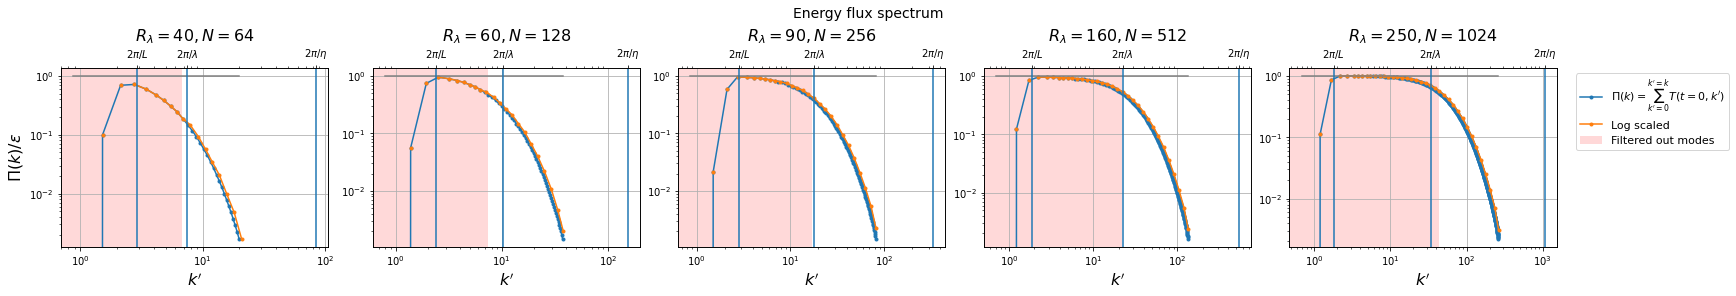

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=len(data_set), constrained_layout=True,figsize=(4*len(data_set)+4,4))
fig.suptitle(r'Energy flux spectrum', size=14) 
for i in list(range(len(data_set))) :
    simu = data_set[i]
    it = len(data_set[i]['t_total']['time'])//2
    simu['flux_spec'] = np.zeros(shape=len(simu['k']), dtype=float)
    simu['flux_spec_log'] = np.zeros(shape=len(simu['k_log']), dtype=float)
    [temp1, temp2, simu['energy_tranfer_log']] = logscale_spec(simu['k'], simu['nb_of_modes'], simu['t_total']['data'][it,:], log_scale_base, 0)
    for ik in list(range(len(simu['k']))) :
        simu['flux_spec'][ik] = -np.sum(simu['t_total']['data'][it,0:ik:])
    for ik in list(range(len(simu['k_log']))) :
        simu['flux_spec_log'][ik] = -np.sum(simu['energy_tranfer_log'][0:ik:])
    norm_coef = 1.0/simu['dissip_rate']
    indices = slice(0,simu['ik_max'])
    ax[i].plot(simu['k'][indices]*simu['k_norm'], simu['flux_spec'][indices]*norm_coef, '.-', label=r'$\Pi(k) = \sum_{k^\prime=0}^{k^\prime = k} T(t=0, k^\prime)$')
    ax[i].plot(simu['k_log']*simu['k_norm'], simu['flux_spec_log']*norm_coef, '.-', label='Log scaled')
    ax[i].plot(simu['k'][indices]*simu['k_norm'], np.full_like(simu['k'], simu['dissip_rate'])[indices]*norm_coef, color='gray')
    ax[i].set(xscale='log',yscale='log',xlabel=r'$k^\prime$', title=simu['legend']); ax[i].grid()
    if (i == 0) : ax[i].set(ylabel=r'$\Pi(k) / \epsilon$')
    # show the range of the filtered out wavenumbers
    ax[i].axvspan(0, simu['filter_cut_off_k']*simu['k_norm'], facecolor='red', alpha=0.15, label='Filtered out modes')
    # plot spatial scales
    vertical_lines = 2.0*np.pi/simu['spatial_scales']*simu['k_norm']
    for line in vertical_lines : ax[i].axvline(x=line)     
    ax2 = ax[i].twiny(); ax2.set(xscale=ax[i].get_xscale(), yscale=ax[i].get_yscale(), xlim = ax[i].get_xlim())
    ax2.set_xticks(vertical_lines); ax2.set_xticklabels([r'$2\pi/L$', r'$2\pi/\lambda$', r'$2\pi/\eta$'])
    if (i == len(data_set)-1) : lgd = ax[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Energy transfer spectrum from T(t=0,k)

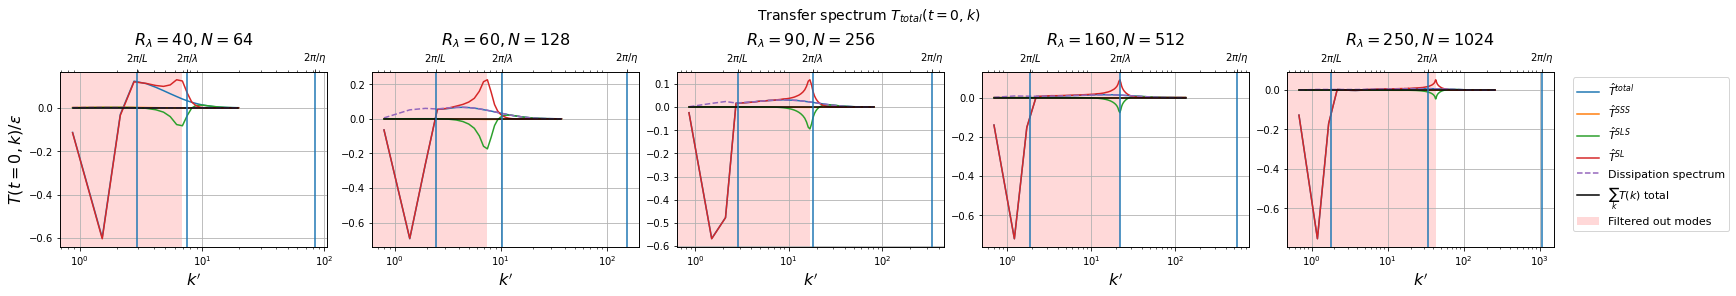

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=len(data_set), constrained_layout=True,figsize=(4*len(data_set)+4,4))
fig.suptitle(r'Transfer spectrum $T_{total} (t=0,k)$', size=14) 
for i in list(range(len(data_set))) :
    simu = data_set[i]
    it = len(data_set[i]['t_total']['time'])//2
    norm_coef = 1.0/ simu['dissip_rate']
    indices = slice(0,simu['ik_max'])
    for dictionary in [simu['t_total'], simu['t_sss'], simu['t_sls'], simu['t_sl']] : 
        ax[i].plot(simu['k'][indices]*simu['k_norm'], dictionary['data'][it,indices]*simu['spher_coef'][indices]*norm_coef, '-', label=dictionary['legend'])
    ax[i].plot(simu['k'][indices]*simu['k_norm'], simu['dissipation_spec'][indices]*simu['spher_coef'][indices]*norm_coef, '--', label='Dissipation spectrum')
    ax[i].plot(simu['k'][indices]*simu['k_norm'], np.full_like(simu['k'][indices], np.sum(simu['t_total']['data'][it,::]))*norm_coef, '-', color='black', label=r'$\sum_k T(k)$ total')
    ax[i].set(xscale='log',yscale='linear',xlabel=r'$k^\prime$', title=simu['legend']); ax[i].grid()
    if (i == 0) : ax[i].set(ylabel=r'$T(t=0,k) / \epsilon$')
    # show the range of the filtered out wavenumbers
    ax[i].axvspan(0, simu['filter_cut_off_k']*simu['k_norm'], facecolor='red', alpha=0.15, label='Filtered out modes')
    # plot spatial scales
    vertical_lines = 2.0*np.pi/simu['spatial_scales']*simu['k_norm']
    for line in vertical_lines : ax[i].axvline(x=line)     
    ax2 = ax[i].twiny(); ax2.set(xscale=ax[i].get_xscale(), yscale=ax[i].get_yscale(), xlim = ax[i].get_xlim())
    ax2.set_xticks(vertical_lines); ax2.set_xticklabels([r'$2\pi/L$', r'$2\pi/\lambda$', r'$2\pi/\eta$'])
    if (i == len(data_set)-1) : lgd = ax[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [22]:
# # LOG SCALED
# fig, ax = plt.subplots(nrows=1, ncols=len(data_set), constrained_layout=True,figsize=(4*len(data_set)+4,4))
# fig.suptitle(r'Transfer spectrum $T_{total} (t=0,k)$', size=14) 
# for i in list(range(len(data_set))) :
#     simu = data_set[i]
#     it = len(data_set[i]['t_total']['time'])//2
#     norm_coef = 1.0/ simu['dissip_rate']
#     for dictionary in [simu['t_total'], simu['t_sss'], simu['t_sls'], simu['t_sl']] : 
#         [temp1, temp2, dictionary['transfer_log']] = logscale_spec(simu['k'], simu['nb_of_modes'], dictionary['data'][it,:], log_scale_base, 0)
#         ax[i].plot(simu['k_log']*simu['k_norm'], dictionary['transfer_log']*norm_coef, '.-', label=dictionary['legend'])
#     ax[i].plot(simu['k'][indices]*simu['k_norm'], simu['dissipation_spec'][indices]*simu['spher_coef'][indices]*norm_coef, '--', label='Dissipation spectrum')
#     ax[i].plot(simu['k'][indices]*simu['k_norm'], np.full_like(simu['k'][indices], np.sum(simu['t_total']['data'][it,::]))*norm_coef, '-', color='black', label=r'$\sum_k T(k)$ total')
#     ax[i].set(xscale='log',yscale='log',xlabel=r'$k^\prime$', title=simu['legend']); ax[i].grid()
#     if (i == 0) : ax[i].set(ylabel=r'$T(t=0,k) / \epsilon$')
#     # show the range of the filtered out wavenumbers
#     ax[i].axvspan(0, simu['filter_cut_off_k']*simu['k_norm'], facecolor='red', alpha=0.15, label='Filtered out modes')
#     # plot spatial scales
#     vertical_lines = 2.0*np.pi/simu['spatial_scales']*simu['k_norm']
#     for line in vertical_lines : ax[i].axvline(x=line)     
#     ax2 = ax[i].twiny(); ax2.set(xscale=ax[i].get_xscale(), yscale=ax[i].get_yscale(), xlim = ax[i].get_xlim())
#     ax2.set_xticks(vertical_lines); ax2.set_xticklabels([r'$2\pi/L$', r'$2\pi/\lambda$', r'$2\pi/\eta$'])
#     if (i == len(data_set)-1) : lgd = ax[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

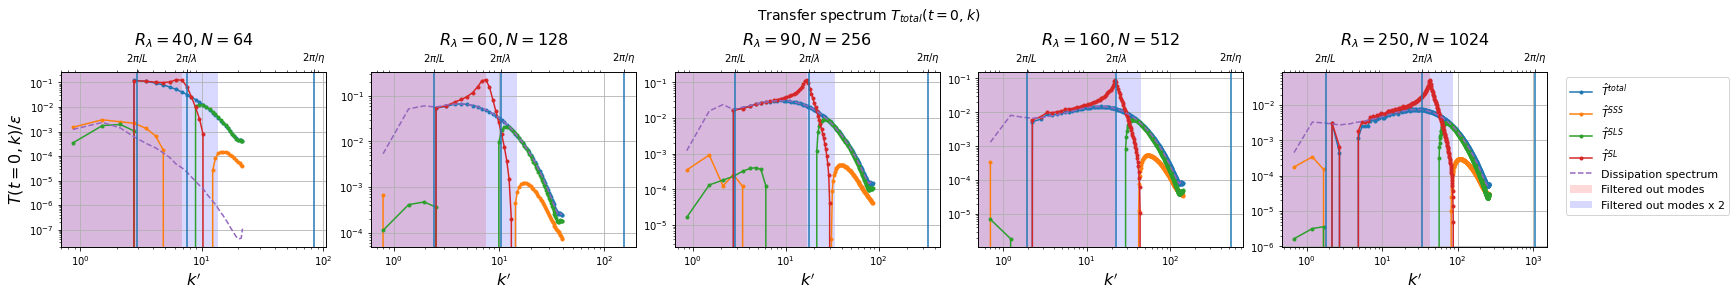

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=len(data_set), constrained_layout=True,figsize=(4*len(data_set)+4,4))
fig.suptitle(r'Transfer spectrum $T_{total} (t=0,k)$', size=14) 
for i in list(range(len(data_set))) :
    simu = data_set[i]
    it = len(data_set[i]['t_total']['time'])//2
    norm_coef = 1.0/ simu['dissip_rate']
    for dictionary in [simu['t_total'], simu['t_sss'], simu['t_sls'], simu['t_sl']] : 
        ax[i].plot(simu['k'][indices]*simu['k_norm'], dictionary['data'][it,indices]*simu['spher_coef'][indices]*norm_coef, '.-', label=dictionary['legend'])
    ax[i].plot(simu['k'][indices]*simu['k_norm'], simu['dissipation_spec'][indices]*simu['spher_coef'][indices]*norm_coef, '--', label='Dissipation spectrum')
    #ax[i].plot(simu['k'][indices]*simu['k_norm'], np.full_like(simu['k'][indices], np.sum(simu['t_total']['data'][it,::]))*norm_coef, '-', color='black', label=r'$\sum_k T(k)$ total')
    ax[i].set(xscale='log',yscale='log',xlabel=r'$k^\prime$', title=simu['legend']); ax[i].grid()
    if (i == 0) : ax[i].set(ylabel=r'$T(t=0,k) / \epsilon$')
    # show the range of the filtered out wavenumbers
    ax[i].axvspan(0, simu['filter_cut_off_k']*simu['k_norm'], facecolor='red', alpha=0.15, label='Filtered out modes')
    ax[i].axvspan(0, 2.0*simu['filter_cut_off_k']*simu['k_norm'], facecolor='blue', alpha=0.15, label='Filtered out modes x 2')
    # plot spatial scales
    vertical_lines = 2.0*np.pi/simu['spatial_scales']*simu['k_norm']
    for line in vertical_lines : ax[i].axvline(x=line)     
    ax2 = ax[i].twiny(); ax2.set(xscale=ax[i].get_xscale(), yscale=ax[i].get_yscale(), xlim = ax[i].get_xlim())
    ax2.set_xticks(vertical_lines); ax2.set_xticklabels([r'$2\pi/L$', r'$2\pi/\lambda$', r'$2\pi/\eta$'])
    if (i == len(data_set)-1) : lgd = ax[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Two-point spatio-temporal correlation function

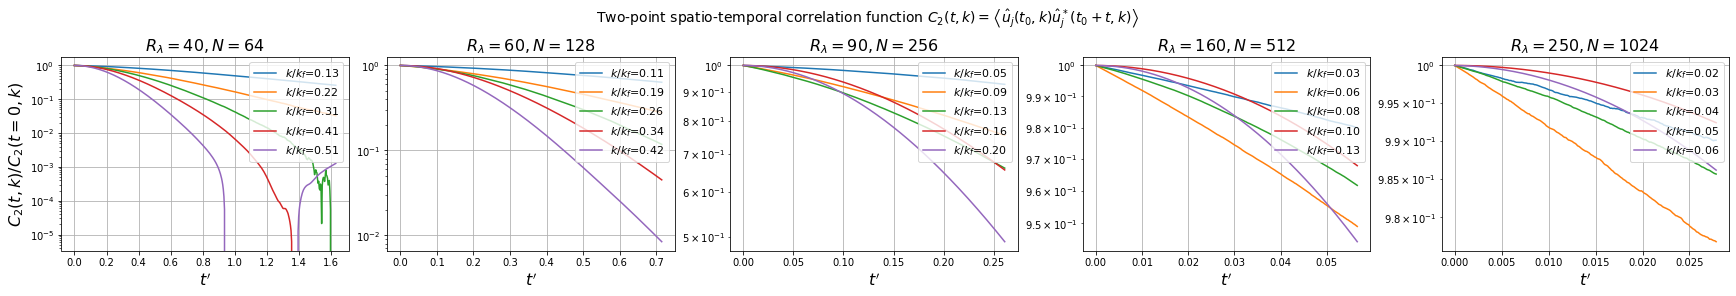

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=len(data_set), constrained_layout=True,figsize=(4*len(data_set)+4,4))
fig.suptitle(r'Two-point spatio-temporal correlation function $C_2(t,k) = \left< \hat{u}_j(t_0, k) \hat{u}_j^* (t _0 + t, k)\right>$', size=14) 
for i in list(range(len(data_set))) :
    simu = data_set[i]
    data_dict=simu['corr']
    #for ik in simu['indices_of_k_to_plot'] :
    for ik in list(range(5))  :
        ax[i].plot(data_dict['time']/simu['t0'], data_dict['data'][:,ik] / data_dict['data'][0,ik], '-', label=r'$k/k_f$=%2.2f' % (simu['k'][ik]/simu['filter_cut_off_k']))
    ax[i].set(xscale='linear',yscale='log', xlabel=r'$t^\prime$', title=simu['legend']); ax[i].grid()
    #ax[i].set(xlim=[0,0.3])
    if (i == 0) : ax[i].set(ylabel=r'$C_2(t,k) / C_2(t=0,k)$')
    lgd = ax[i].legend(loc='upper right')

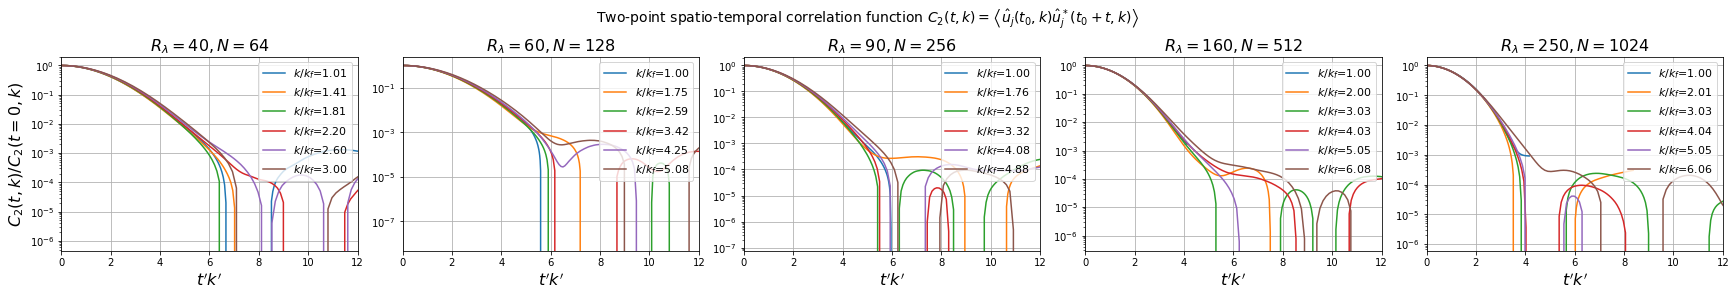

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=len(data_set), constrained_layout=True,figsize=(4*len(data_set)+4,4))
fig.suptitle(r'Two-point spatio-temporal correlation function $C_2(t,k) = \left< \hat{u}_j(t_0, k) \hat{u}_j^* (t _0 + t, k)\right>$', size=14) 
for i in list(range(len(data_set))) :
    simu = data_set[i]
    data_dict=simu['corr']
    for ik in simu['indices_of_k_to_plot'] :
        ax[i].plot(data_dict['time']/simu['t0']*simu['k'][ik]*simu['L'], data_dict['data'][:,ik] / data_dict['data'][0,ik], '-', label=r'$k/k_f$=%2.2f' % (simu['k'][ik]/simu['filter_cut_off_k']))
    ax[i].set(xscale='linear',yscale='log', xlabel=r'$t^\prime k^\prime$', title=simu['legend']); ax[i].grid()
    ax[i].set(xlim=[0,12])
    if (i == 0) : ax[i].set(ylabel=r'$C_2(t,k) / C_2(t=0,k)$')
    lgd = ax[i].legend(loc='upper right')

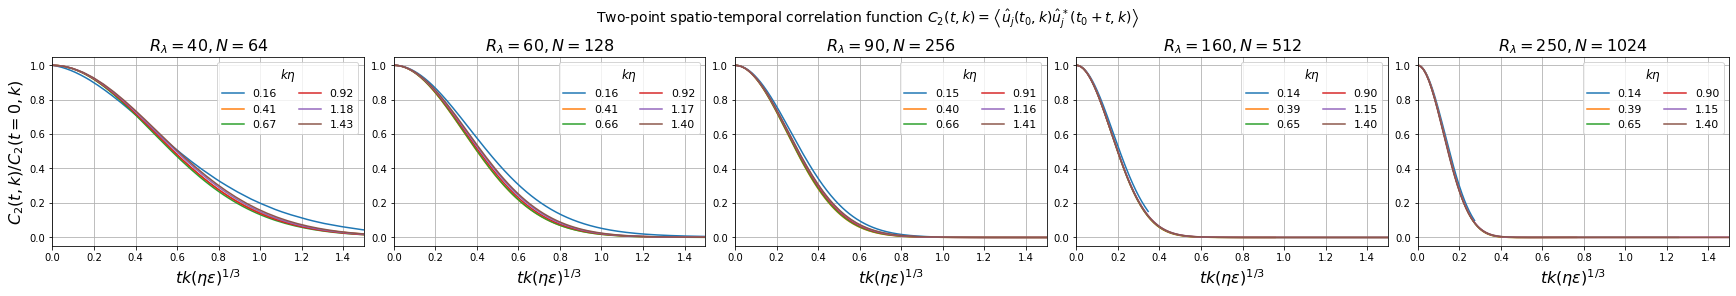

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=len(data_set), constrained_layout=True,figsize=(4*len(data_set)+4,4))
fig.suptitle(r'Two-point spatio-temporal correlation function $C_2(t,k) = \left< \hat{u}_j(t_0, k) \hat{u}_j^* (t _0 + t, k)\right>$', size=14) 
for i in list(range(len(data_set))) :
    simu = data_set[i]
    data_dict=simu['corr']
    for ik in simu['indices_of_k_to_plot2'] :
        ax[i].plot(data_dict['time']*simu['k'][ik]*(simu['eta']*simu['dissip_rate'])**(1.0/3.0), data_dict['data'][:,ik] / data_dict['data'][0,ik], '-', label=r'%2.2f' % (simu['k'][ik]*simu['eta']))
    ax[i].set(xscale='linear',yscale='linear', xlabel=r'$t k (\eta \epsilon)^{1/3}$', title=simu['legend']); ax[i].grid()
    ax[i].set(xlim=[0,1.5])
    if (i == 0) : ax[i].set(ylabel=r'$C_2(t,k) / C_2(t=0,k)$')
    lgd = ax[i].legend(loc='upper right', title=r'$k\eta$', title_fontsize=12, ncol=2)

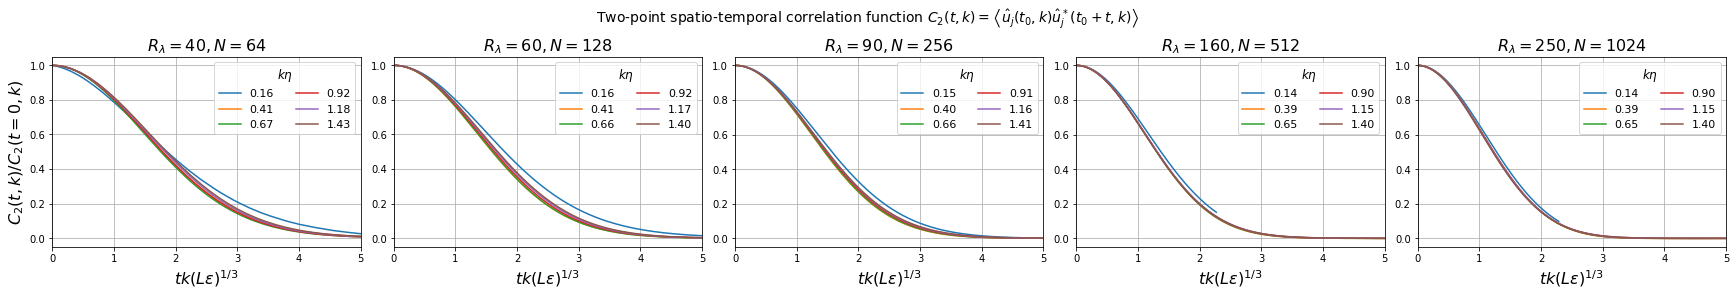

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=len(data_set), constrained_layout=True,figsize=(4*len(data_set)+4,4))
fig.suptitle(r'Two-point spatio-temporal correlation function $C_2(t,k) = \left< \hat{u}_j(t_0, k) \hat{u}_j^* (t _0 + t, k)\right>$', size=14) 
for i in list(range(len(data_set))) :
    simu = data_set[i]
    data_dict=simu['corr']
    for ik in simu['indices_of_k_to_plot2'] :
        ax[i].plot(data_dict['time']*simu['k'][ik]*(simu['L']*simu['dissip_rate'])**(1.0/3.0), data_dict['data'][:,ik] / data_dict['data'][0,ik], '-', label=r'%2.2f' % (simu['k'][ik]*simu['eta']))
    ax[i].set(xscale='linear',yscale='linear', xlabel=r'$t k (L \epsilon)^{1/3}$', title=simu['legend']); ax[i].grid()
    ax[i].set(xlim=[0,5.0])
    if (i == 0) : ax[i].set(ylabel=r'$C_2(t,k) / C_2(t=0,k)$')
    lgd = ax[i].legend(loc='upper right', title=r'$k\eta$', title_fontsize=12, ncol=2)

# Advection-velocity correlation

## Total advection-velocity correlation

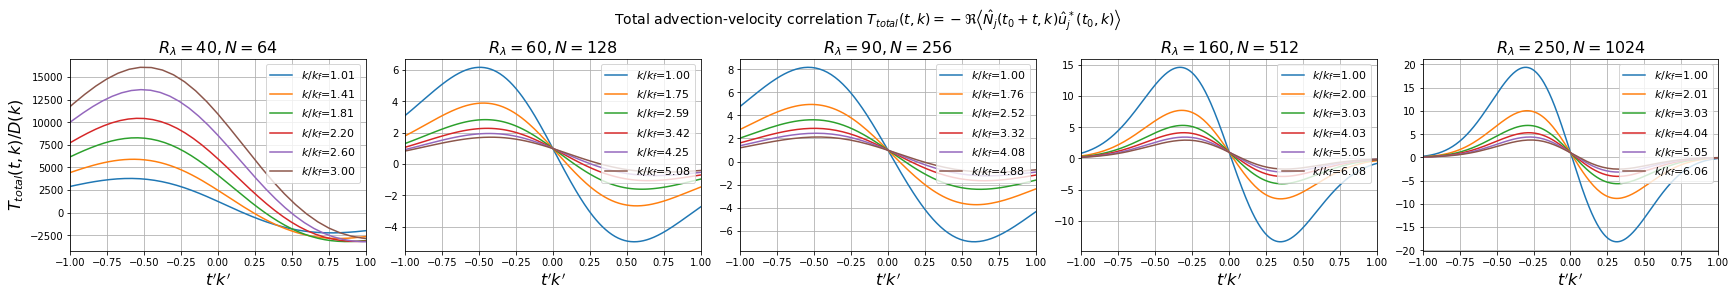

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=len(data_set), constrained_layout=True,figsize=(4*len(data_set)+4,4))
fig.suptitle(r'Total advection-velocity correlation $T_{total}(t,k) = -\Re \left< \hat{N}_j(t_0 + t, k) \hat{u}_j^* (t _0, k)\right>$', size=14) 
for i in list(range(len(data_set))) :
    simu = data_set[i]
    data_dict=simu['t_total']
    for ik in simu['indices_of_k_to_plot'] :
        ax[i].plot(data_dict['time']/simu['t0']*simu['k'][ik]*simu['k_norm'], data_dict['data'][:,ik] / simu['dissipation_spec'][ik], '-', label=r'$k/k_f$=%2.2f' % (simu['k'][ik]/simu['filter_cut_off_k']))
    ax[i].set(xscale='linear',yscale='linear', xlabel=r'$t^\prime k^\prime$', title=simu['legend']); ax[i].grid()
    ax[i].set(xlim=[-1,1])
    if (i == 0) : ax[i].set(ylabel=r'$T_{total}(t,k) / D(k)$')
    lgd = ax[i].legend(loc='upper right')

## Filtered SL advection-velocity correlation (non-local interations)

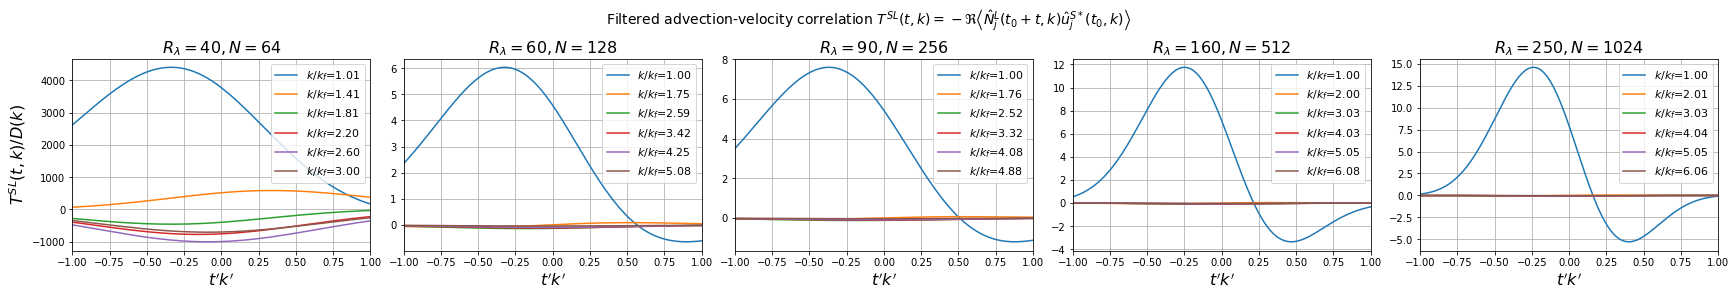

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=len(data_set), constrained_layout=True,figsize=(4*len(data_set)+4,4))
fig.suptitle(r'Filtered advection-velocity correlation $T^{SL}(t,k) = -\Re \left< \hat{N}^{L}_j(t_0 + t, k) \hat{u}_j^{S*} (t _0, k)\right>$', size=14) 
for i in list(range(len(data_set))) :
    simu = data_set[i]
    data_dict=simu['t_sl']
    for ik in simu['indices_of_k_to_plot'] :
        ax[i].plot(data_dict['time']/simu['t0']*simu['k'][ik]*simu['k_norm'], data_dict['data'][:,ik] / simu['dissipation_spec'][ik], '-', label=r'$k/k_f$=%2.2f' % (simu['k'][ik]/simu['filter_cut_off_k']))
    ax[i].set(xscale='linear',yscale='linear', xlabel=r'$t^\prime k^\prime$', title=simu['legend']); ax[i].grid()
    ax[i].set(xlim=[-1,1])
    if (i == 0) : ax[i].set(ylabel=r'$T^{SL}(t,k) / D(k)$')
    lgd = ax[i].legend(loc='upper right')

## Filtered SLS advection-velocity correlation (sweeping)

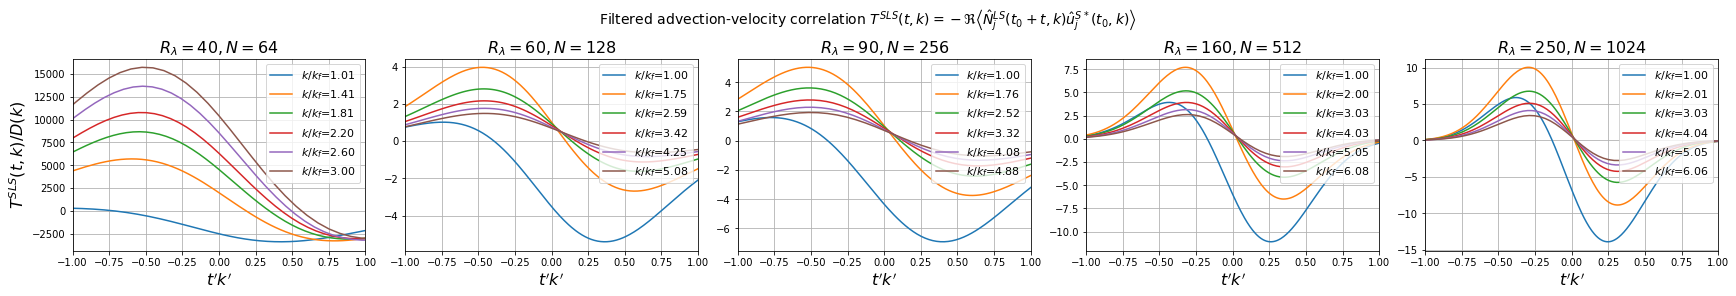

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=len(data_set), constrained_layout=True,figsize=(4*len(data_set)+4,4))
fig.suptitle(r'Filtered advection-velocity correlation $T^{SLS}(t,k) = -\Re \left< \hat{N}^{LS}_j(t_0 + t, k) \hat{u}_j^{S*} (t _0, k)\right>$', size=14) 
for i in list(range(len(data_set))) :
    simu = data_set[i]
    data_dict=simu['t_sls']
    for ik in simu['indices_of_k_to_plot'] :
        norm_coef = 1.0 / simu['dissipation_spec'][ik]
        #norm_coef = 1.0 / np.max(simu['t_sls']['data'][:,ik])
        ax[i].plot(data_dict['time']/simu['t0']*simu['k'][ik]*simu['k_norm'], data_dict['data'][:,ik] * norm_coef, '-', label=r'$k/k_f$=%2.2f' % (simu['k'][ik]/simu['filter_cut_off_k']))
    ax[i].set(xscale='linear',yscale='linear', xlabel=r'$t^\prime k^\prime$', title=simu['legend']); ax[i].grid()
    ax[i].set(xlim=[-1,1])
    if (i == 0) : ax[i].set(ylabel=r'$T^{SLS}(t,k) / D(k)$')
    lgd = ax[i].legend(loc='upper right')

## Filtered SSS advection-velocity correlation (small scales only)

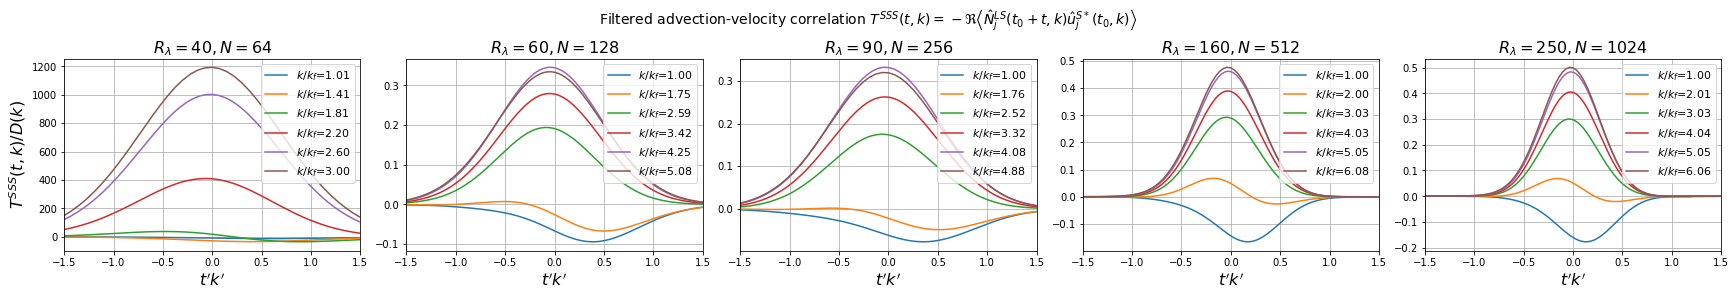

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=len(data_set), constrained_layout=True,figsize=(4*len(data_set)+4,4))
fig.suptitle(r'Filtered advection-velocity correlation $T^{SSS}(t,k) = -\Re \left< \hat{N}^{LS}_j(t_0 + t, k) \hat{u}_j^{S*} (t _0, k)\right>$', size=14) 
for i in list(range(len(data_set))) :
    simu = data_set[i]
    data_dict=simu['t_sss']
    for ik in simu['indices_of_k_to_plot'] :
        norm_coef = 1.0/simu['dissipation_spec'][ik]
        ax[i].plot(data_dict['time']/simu['t0']*simu['k'][ik]*simu['k_norm'], data_dict['data'][:,ik] * norm_coef, '-', label=r'$k/k_f$=%2.2f' % (simu['k'][ik]/simu['filter_cut_off_k']))
    ax[i].set(xscale='linear',yscale='linear', xlabel=r'$t^\prime k^\prime$', title=simu['legend']); ax[i].grid()
    ax[i].set(xlim=[-1.5,1.5])
    if (i == 0) : ax[i].set(ylabel=r'$T^{SSS}(t,k) / D(k)$')
    lgd = ax[i].legend(loc='upper right')

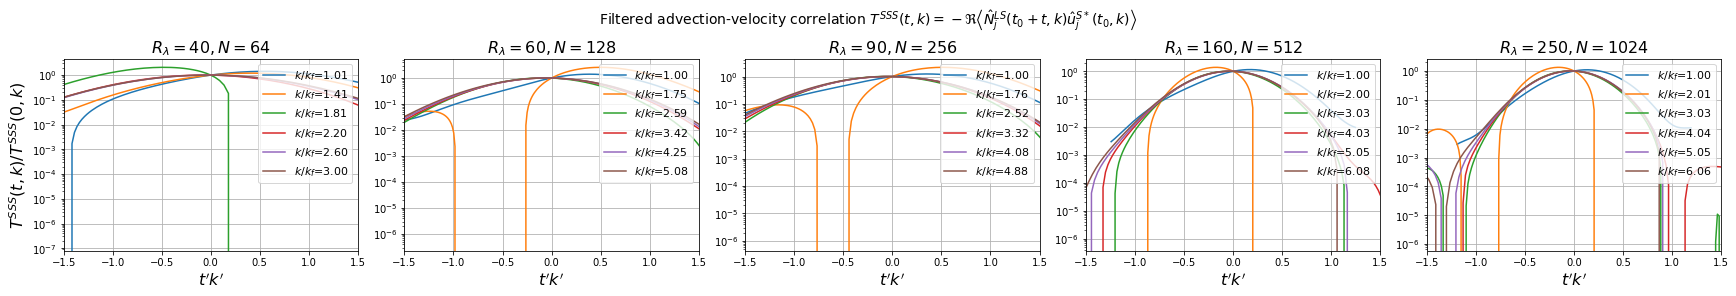

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=len(data_set), constrained_layout=True,figsize=(4*len(data_set)+4,4))
fig.suptitle(r'Filtered advection-velocity correlation $T^{SSS}(t,k) = -\Re \left< \hat{N}^{LS}_j(t_0 + t, k) \hat{u}_j^{S*} (t _0, k)\right>$', size=14) 
for i in list(range(len(data_set))) :
    simu = data_set[i]
    data_dict=simu['t_sss']
    it0 = len(data_dict['time'])//2
    for ik in simu['indices_of_k_to_plot'] :
        norm_coef = 1.0/simu['t_sss']['data'][it0,ik]
        ax[i].plot(data_dict['time']/simu['t0']*simu['k'][ik]*simu['k_norm'], data_dict['data'][:,ik] * norm_coef, '-', label=r'$k/k_f$=%2.2f' % (simu['k'][ik]/simu['filter_cut_off_k']))
    ax[i].set(xscale='linear',yscale='log', xlabel=r'$t^\prime k^\prime$', title=simu['legend']); ax[i].grid()
    ax[i].set(xlim=[-1.5,1.5])
    if (i == 0) : ax[i].set(ylabel=r'$T^{SSS}(t,k) / T^{SSS}(0,k)$')
    lgd = ax[i].legend(loc='upper right')

# Correlation fit

## Fitting computation

In [33]:
# Define the functions to fit

def linear_mult_gaussian(x, a, b, c):   
    return c*(1.0-b*x) * np.exp(-a*x**2.0) 
def linear_mult_gaussian_jacobian(x, a, b, c):   
    return np.transpose([-(x**2.0)*c*(1.0-b*x) * np.exp(-a * x**2.0), -c*x*np.exp(-a * x**2.0), (1.0-b*x) * np.exp(-a * x**2.0)])

def simple_gaussian(x, a, c):   
    return np.exp(-a * (x)**2.0 + c) 
def simple_gaussian_jacobian(x, a, c):   
    return np.transpose([-(x**2.0)*np.exp(-a * (x)**2.0 + c), np.exp(-a * (x)**2.0 + c)])

In [34]:
def try_to_fit(curve_function, xdata, ydata, sigma_ydata=None, jacobian_function=None) :
    number_of_params_of_optimization = len(signature(curve_function).parameters)-1
    coefficients = np.ndarray(shape=(number_of_params_of_optimization), dtype=float) 
    covariance_matrix = np.ndarray(shape=(number_of_params_of_optimization, number_of_params_of_optimization), dtype=float) 
    try :
        coefficients, covariance_matrix = curve_fit(curve_function, xdata, ydata, sigma=sigma_ydata, jac=jacobian_function, absolute_sigma=False)
    except :
        #print('[DEBUG] Failed optimization for ik = ', ik)
        coefficients.fill(np.nan); covariance_matrix.fill(np.nan)
    return [coefficients, covariance_matrix]

In [35]:
# allocate array to store the coefficents of fitting
for simu in data_set : 
    for dictionary in [simu['t_total'], simu['t_sss'], simu['t_sls'], simu['t_sl']] : 
        dictionary.update({'fit_func': linear_mult_gaussian, 'fit_jacobian' : linear_mult_gaussian_jacobian})
    #simu['corr'].update({'fit_func': simple_gaussian, 'fit_jacobian' : simple_gaussian_jacobian})
    simu['corr'].update({'fit_func': simple_gaussian, 'fit_jacobian' : simple_gaussian_jacobian})
    #simu['t_sss'].update({'fit_func': simple_gaussian, 'fit_jacobian' : simple_gaussian_jacobian})
    for dictionary in [simu['t_total'], simu['t_sss'], simu['t_sls'], simu['t_sl'], simu['corr']] : 
        nb_of_params = len(signature(dictionary['fit_func']).parameters)-1
        dictionary.update({'fit_coef' : np.ndarray(shape=(len(simu['k']), nb_of_params), dtype=float)})
        dictionary.update({'fit_cov_matrix' : np.ndarray(shape=(len(simu['k']), nb_of_params, nb_of_params), dtype=float)})
        dictionary.update({'fit_coef_tk' : np.ndarray(shape=(len(simu['k']), nb_of_params), dtype=float)})
        dictionary.update({'fit_cov_matrix_tk' : np.ndarray(shape=(len(simu['k']), nb_of_params, nb_of_params), dtype=float)})
        dictionary.update({'fit_coef_tketa' : np.ndarray(shape=(len(simu['k']), nb_of_params), dtype=float)})
        dictionary.update({'fit_cov_matrix_tketa' : np.ndarray(shape=(len(simu['k']), nb_of_params, nb_of_params), dtype=float)})
        dictionary.update({'perr' : np.ndarray(shape=(len(simu['k']),nb_of_params), dtype=float)})
        dictionary.update({'perr_tk' : np.ndarray(shape=(len(simu['k']),nb_of_params), dtype=float)})
        dictionary.update({'perr_tketa' : np.ndarray(shape=(len(simu['k']),nb_of_params), dtype=float)})
        dictionary.update({'exp_width' : np.ndarray(shape=(len(simu['k']), nb_of_params), dtype=float)})

In [36]:
# width of the exponent
for simu in data_set : 
    dictionary = simu['corr']
    for ik in range(len(simu['k'])) :
        ydata = dictionary['data'][:,ik]/dictionary['data'][0,ik]
        xdata = dictionary['time']/simu['t0']*simu['k'][ik]*simu['L']
        try:
            width_index = len(dictionary['time']) - np.searchsorted(np.flip(ydata), 1.0/np.e, side='right')
            dictionary['exp_width'][ik] = 1.0/(xdata[width_index])**2
        except : 
            width_index = len(dictionary['time']) - 1
            dictionary['exp_width'][ik] = 1.0/(xdata[-1])**2

In [37]:
# fit vs t/t0
for simu in data_set : 
    tk1_fit = -2.5
    tk2_fit = 2.5
    for ik in range(len(simu['k'])) :
        # fit the 2-point correlation function :
        dictionary = simu['corr']
        a = np.searchsorted(dictionary['time']/simu['t0']*simu['k'][ik]*simu['L'], 0.0)
        b = np.searchsorted(dictionary['time']/simu['t0']*simu['k'][ik]*simu['L'], tk2_fit)
        xdata = dictionary['time'][a:b]/simu['t0']
        normalization_coef = 1.0/dictionary['data'][0,ik]
        #normalization_coef = 1.0 / simu['dissipation_spec'][ik]
        ydata = dictionary['data'][a:b,ik] * normalization_coef
        #error = np.sqrt(dictionary['data_var'][a:b, ik])*normalization_coef
        #dictionary['fit_coef'][ik, :] = np.polyfit(xdata, np.log(ydata), 2)
        #dictionary['fit_coef'][ik, :], dictionary['fit_cov_matrix'][ik, :] = try_to_fit(dictionary['fit_func'], xdata, ydata, sigma_ydata=error, jacobian_function=dictionary['fit_jacobian'])
        dictionary['fit_coef'][ik, :], dictionary['fit_cov_matrix'][ik, :] = try_to_fit(dictionary['fit_func'], xdata, ydata, jacobian_function=dictionary['fit_jacobian'])
        dictionary['perr'][ik] = np.sqrt(np.diag(dictionary['fit_cov_matrix'][ik, :]))
        
        # fit the energy transfer functions : 
        a = np.searchsorted(simu['t_total']['time']/simu['t0']*simu['k'][ik]*simu['L'], tk1_fit)
        b = np.searchsorted(simu['t_total']['time']/simu['t0']*simu['k'][ik]*simu['L'], tk2_fit)
        normalization_coef = 1.0 / simu['dissipation_spec'][ik]
        #normalization_coef = 1.0
        for dictionary in [simu['t_total'], simu['t_sss'], simu['t_sls'], simu['t_sl']] : 
            xdata = dictionary['time'][a:b]/simu['t0']
            ydata = dictionary['data'][a:b, ik]*normalization_coef
            #error = np.sqrt(np.abs(dictionary['data_var'][a:b, ik]))*normalization_coef
            #dictionary['fit_coef'][ik, :], dictionary['fit_cov_matrix'][ik, :] = try_to_fit(dictionary['fit_func'], xdata, ydata, sigma_ydata=error, jacobian_function=dictionary['fit_jacobian'])
            dictionary['fit_coef'][ik, :], dictionary['fit_cov_matrix'][ik, :] = try_to_fit(dictionary['fit_func'], xdata, ydata, jacobian_function=dictionary['fit_jacobian'])
            dictionary['perr'][ik] = np.sqrt(np.diag(dictionary['fit_cov_matrix'][ik, :]))

In [38]:
# # fit vs ^z
# for simu in data_set : 
#     tk1_fit = -2.5
#     tk2_fit = 2.5
#     for ik in range(len(simu['k'])) :
#         # fit the 2-point correlation function :
#         dictionary = simu['corr']
#         a = np.searchsorted(dictionary['time']/simu['t0']*simu['k'][ik]*simu['L'], 0.0)
#         b = np.searchsorted(dictionary['time']/simu['t0']*simu['k'][ik]*simu['L'], tk2_fit)
#         xdata = dictionary['time'][a:b]*simu['k'][ik]*(simu['eta']*simu['dissip_rate'])**(1.0/3.0)
#         normalization_coef = 1.0/dictionary['data'][0,ik]
#         #normalization_coef = 1.0 / simu['dissipation_spec'][ik]
#         ydata = dictionary['data'][a:b,ik] * normalization_coef
#         error = np.sqrt(dictionary['data_var'][a:b, ik])*normalization_coef
#         dictionary['fit_coef_tketa'][ik, :], dictionary['fit_cov_matrix_tketa'][ik, :] = try_to_fit(dictionary['fit_func'], xdata, ydata, sigma_ydata=error, jacobian_function=dictionary['fit_jacobian'])
#         dictionary['perr_tketa'][ik,:] = np.sqrt(np.diag(dictionary['fit_cov_matrix_tketa'][ik, :]))
        
#         # fit the energy transfer functions : 
#         a = np.searchsorted(simu['t_total']['time']/simu['t0']*simu['k'][ik]*simu['L'], tk1_fit)
#         b = np.searchsorted(simu['t_total']['time']/simu['t0']*simu['k'][ik]*simu['L'], tk2_fit)
#         normalization_coef = 1.0 / simu['dissipation_spec'][ik]
#         #normalization_coef = 1.0
#         for dictionary in [simu['t_total'], simu['t_sss'], simu['t_sls'], simu['t_sl']] : 
#             xdata = dictionary['time'][a:b]*simu['k'][ik]*(simu['eta']*simu['dissip_rate'])**(1.0/3.0)
#             ydata = dictionary['data'][a:b, ik]*normalization_coef
#             error = np.sqrt(np.abs(dictionary['data_var'][a:b, ik]))*normalization_coef
#             dictionary['fit_coef_tketa'][ik, :], dictionary['fit_cov_matrix_tketa'][ik, :] = try_to_fit(dictionary['fit_func'], xdata, ydata, sigma_ydata=error, jacobian_function=dictionary['fit_jacobian'])
#             dictionary['perr_tketa'][ik,:] = np.sqrt(np.diag(dictionary['fit_cov_matrix_tketa'][ik, :]))

In [39]:
# # fit vs t'k'
# for simu in data_set : 
#     tk1_fit = -5.0
#     tk2_fit = 5.0
#     for ik in range(len(simu['k'])) :
#         # fit the 2-point correlation function :
#         dictionary = simu['corr']
#         a = np.searchsorted(dictionary['time']/simu['t0']*simu['k'][ik]*simu['L'], 0.0)
#         b = np.searchsorted(dictionary['time']/simu['t0']*simu['k'][ik]*simu['L'], tk2_fit)
#         xdata = dictionary['time'][a:b]/simu['t0']*simu['k'][ik]*simu['L']
#         normalization_coef = 1.0/dictionary['data'][0,ik]
#         #normalization_coef = 1.0 / simu['dissipation_spec'][ik]
#         ydata = dictionary['data'][a:b,ik] * normalization_coef
#         error = np.sqrt(dictionary['data_var'][a:b, ik])*normalization_coef
#         dictionary['fit_coef_tk'][ik, :], dictionary['fit_cov_matrix_tk'][ik, :] = try_to_fit(dictionary['fit_func'], xdata, ydata, sigma_ydata=error, jacobian_function=dictionary['fit_jacobian'])
#         dictionary['perr_tk'][ik,:] = np.sqrt(np.diag(dictionary['fit_cov_matrix_tk'][ik, :]))
        
#         # fit the energy transfer functions : 
#         a = np.searchsorted(simu['t_total']['time']/simu['t0']*simu['k'][ik]*simu['L'], tk1_fit)
#         b = np.searchsorted(simu['t_total']['time']/simu['t0']*simu['k'][ik]*simu['L'], tk2_fit)
#         normalization_coef = 1.0 / simu['dissipation_spec'][ik]
#         #normalization_coef = 1.0
#         for dictionary in [simu['t_total'], simu['t_sss'], simu['t_sls'], simu['t_sl']] : 
#             xdata = dictionary['time'][a:b]/simu['t0']*simu['k'][ik]*simu['L']
#             ydata = dictionary['data'][a:b, ik]*normalization_coef
#             error = np.sqrt(np.abs(dictionary['data_var'][a:b, ik]))*normalization_coef
#             dictionary['fit_coef_tk'][ik, :], dictionary['fit_cov_matrix_tk'][ik, :] = try_to_fit(dictionary['fit_func'], xdata, ydata, sigma_ydata=error, jacobian_function=dictionary['fit_jacobian'])
#             dictionary['perr_tk'][ik,:] = np.sqrt(np.diag(dictionary['fit_cov_matrix_tk'][ik, :]))

## Results of fit for different T functions

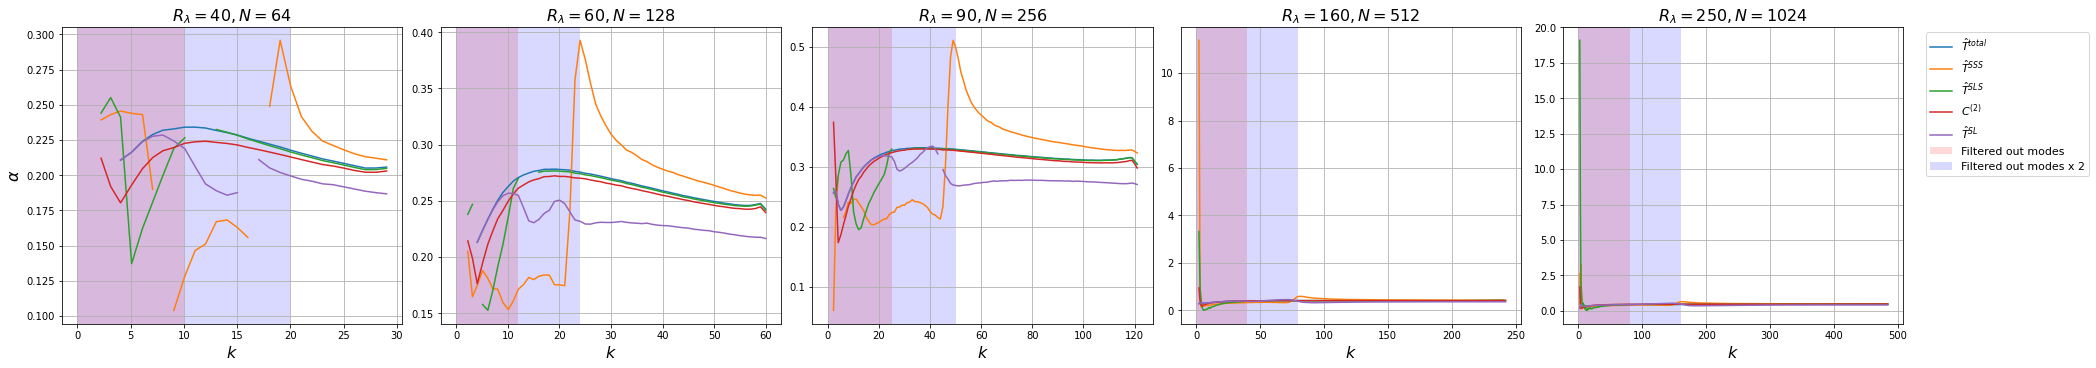

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=len(data_set), constrained_layout=True,figsize=(5*len(data_set)+4,5))
#fig.suptitle(r'Fitting result: $\alpha_s = a/(kL)^2$', size=14) 
for i in list(range(len(data_set))) :
    simu = data_set[i]
    ik1 = simu['ikf']
    ik1 = simu['ik2f']
    ik1 = 1
    indices = slice(ik1,simu['ik_max'])
    normalization = 1.0/((simu['k'][indices]*simu['L'])**2.0)
    #normalization = 1.0
    for dictionary in [simu['t_total'], simu['t_sss'], simu['t_sls'], simu['corr'], simu['t_sl']] : 
        ax[i].plot(simu['k'][indices], np.abs(dictionary['fit_coef'][indices,0]*normalization), '-', label=dictionary['legend'])
    #error_dict=simu['t_total']
    #ax[i].errorbar(simu['k'][indices], error_dict['fit_coef'][indices,0]*normalization, yerr=error_dict['fit_cov_matrix'][indices,0,0]*normalization)
    ax[i].set(xscale='linear', yscale='linear', xlabel=r'$k$', title=simu['legend']); ax[i].grid()
    #ax[i].set(ylim=[0.05,0.25])
    if (i == 0) : ax[i].set(ylabel=r'$\alpha$')
    # show the range of the filtered out wavenumbers
    ax[i].axvspan(0, simu['filter_cut_off_k'], facecolor='red', alpha=0.15, label='Filtered out modes')
    ax[i].axvspan(0, 2.0*simu['filter_cut_off_k'], facecolor='blue', alpha=0.15, label='Filtered out modes x 2')
#     # plot spatial scales
#     vertical_lines = 2.0*np.pi/simu['spatial_scales']
#     for line in vertical_lines : ax[i].axvline(x=line)     
#     ax2 = ax[i].twiny(); ax2.set(xscale=ax[i].get_xscale(), yscale=ax[i].get_yscale(), xlim = ax[i].get_xlim())
#     ax2.set_xticks(vertical_lines); ax2.set_xticklabels([r'$2\pi/L$', r'$2\pi/\lambda$', r'$2\pi/\eta$'])
    if (i == len(data_set)-1) : lgd = ax[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

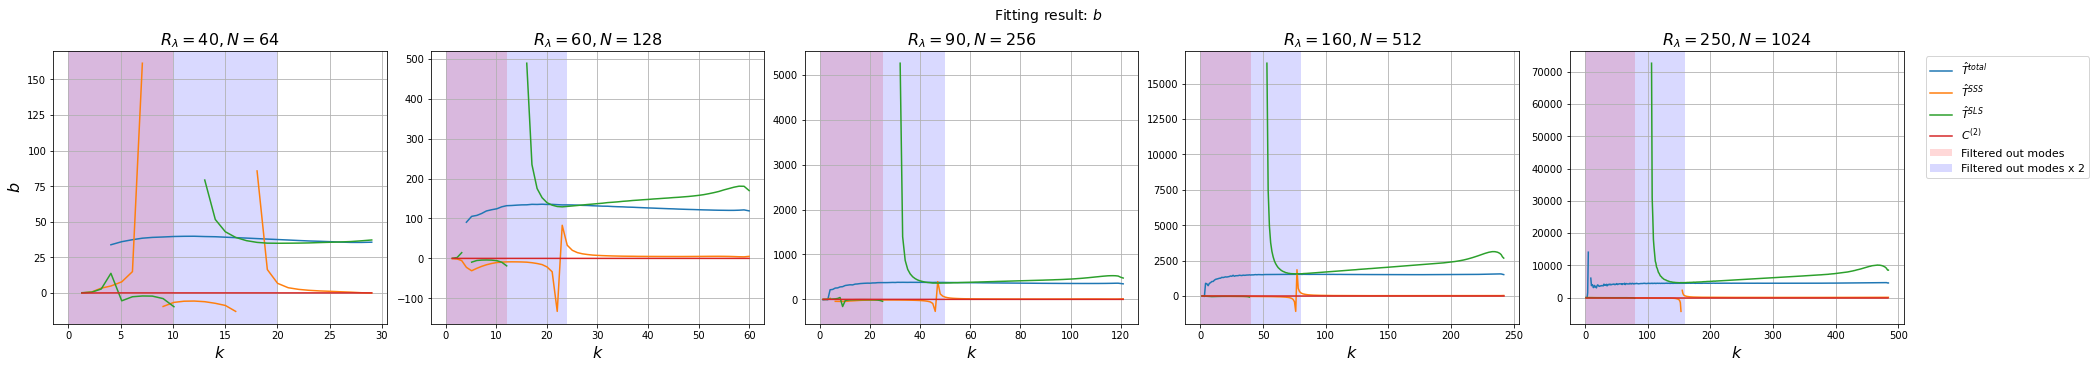

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=len(data_set), constrained_layout=True,figsize=(5*len(data_set)+4,5))
fig.suptitle(r'Fitting result: $b$', size=14) 
for i in list(range(len(data_set))) :
    simu = data_set[i]
    ik1 = simu['ik2f']
    ik1 = 0
    indices = slice(ik1,simu['ik_max'])
    for dictionary in [simu['t_total'], simu['t_sss'], simu['t_sls'], simu['corr']] : 
        ax[i].plot(simu['k'][indices], dictionary['fit_coef'][indices,1], '-', label=dictionary['legend'])
#     error_dict=simu['t_sss']
#     ax[i].errorbar(simu['k'][indices], error_dict['fit_coef'][indices,1], yerr=error_dict['fit_cov_matrix'][indices,1,1])
    ax[i].set(xscale='linear',yscale='linear', xlabel=r'$k$', title=simu['legend']); ax[i].grid()
    #ax[i].set(xlim=[0,2])
    if (i == 0) : ax[i].set(ylabel=r'$b$')
    # show the range of the filtered out wavenumbers
    ax[i].axvspan(0, simu['filter_cut_off_k'], facecolor='red', alpha=0.15, label='Filtered out modes')
    ax[i].axvspan(0, 2.0*simu['filter_cut_off_k'], facecolor='blue', alpha=0.15, label='Filtered out modes x 2')
#     # plot spatial scales
#     vertical_lines = 2.0*np.pi/simu['spatial_scales']
#     for line in vertical_lines : ax[i].axvline(x=line)     
#     ax2 = ax[i].twiny(); ax2.set(xscale=ax[i].get_xscale(), yscale=ax[i].get_yscale(), xlim = ax[i].get_xlim())
#     ax2.set_xticks(vertical_lines); ax2.set_xticklabels([r'$2\pi/L$', r'$2\pi/\lambda$', r'$2\pi/\eta$'])
    if (i == len(data_set)-1) : lgd = ax[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

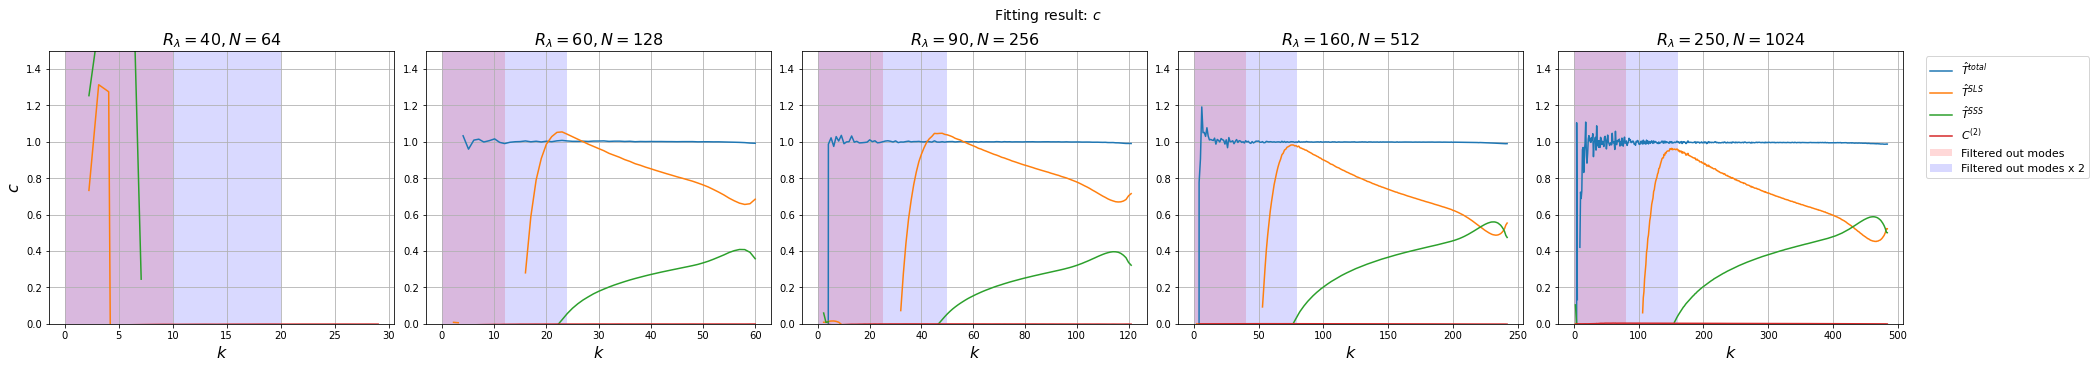

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=len(data_set), constrained_layout=True,figsize=(5*len(data_set)+4,5))
fig.suptitle(r'Fitting result: $c$', size=14) 
for i in list(range(len(data_set))) :
    simu = data_set[i]
    ik1 = simu['ik2f']
    ik1 = 1
    indices = slice(ik1,simu['ik_max'])
    #for dictionary in [simu['t_total'], simu['t_sss'], simu['t_sls']] : 
    for dictionary in [simu['t_total'], simu['t_sls'], simu['t_sss']] : 
        ax[i].plot(simu['k'][indices], dictionary['fit_coef'][indices,2], '-', label=dictionary['legend'])
    dictionary = simu['corr']
    ax[i].plot(simu['k'][indices], dictionary['fit_coef'][indices,1], '-', label=dictionary['legend'])
    ax[i].set(xscale='linear',yscale='linear', xlabel=r'$k$', title=simu['legend']); ax[i].grid()
#     error_dict=simu['t_total']
#     ax[i].errorbar(simu['k'][indices], error_dict['fit_coef'][indices,2], yerr=error_dict['fit_cov_matrix'][indices,2,2])
    ax[i].set(ylim=[0,1.5])
    if (i == 0) : ax[i].set(ylabel=r'$c$')
    # show the range of the filtered out wavenumbers
    ax[i].axvspan(0, simu['filter_cut_off_k'], facecolor='red', alpha=0.15, label='Filtered out modes')
    ax[i].axvspan(0, 2.0*simu['filter_cut_off_k'], facecolor='blue', alpha=0.15, label='Filtered out modes x 2')
#     # plot spatial scales
#     vertical_lines = 2.0*np.pi/simu['spatial_scales']
#     for line in vertical_lines : ax[i].axvline(x=line)     
#     ax2 = ax[i].twiny(); ax2.set(xscale=ax[i].get_xscale(), yscale=ax[i].get_yscale(), xlim = ax[i].get_xlim())
#     ax2.set_xticks(vertical_lines); ax2.set_xticklabels([r'$2\pi/L$', r'$2\pi/\lambda$', r'$2\pi/\eta$'])
    if (i == len(data_set)-1) : lgd = ax[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot results

In [43]:
def find_plateau(data) :
    N = len(data)
    Nmin = N//2
    a = 0; b = N-1
    minAlign = np.max(data-np.mean(data))/np.float(b-a+1)
    for i in list(range(0, N-Nmin-1)) :
        for j in list(range(i+Nmin, N-1)) :
            newAlign = np.max(data[i:j]-np.mean(data[i:j]))/np.float(j-i+1)
            if (newAlign < minAlign) :
                minAlign = newAlign
                a = i; b = j
    return np.mean(data[a:b]), np.std(data[a:b]), (b-a+1), a, b

## Plots for C2

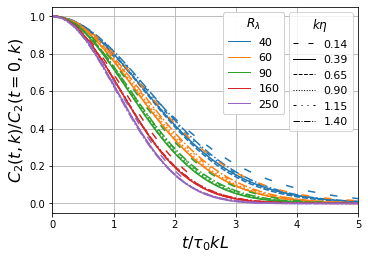

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(5,3.5))
for i in list(range(len(data_set))) :
    simu = data_set[i]
    data_dict=simu['corr']
    for iik in range(len(simu['indices_of_k_to_plot2'])) :
        ik = simu['indices_of_k_to_plot2'][iik]
        ax.plot(data_dict['time']*simu['k'][ik]*(simu['L']/simu['t0']), data_dict['data'][:,ik] / data_dict['data'][0,ik], color=colors[i], linestyle=linestyles[iik])
ax.grid(True)
ax.set(xscale='linear',yscale='linear', xlabel=r'$t/\tau_0 kL $')
ax.set(xlim=[0,5.0])
ax.set(ylabel=r'$C_2(t,k) / C_2(t=0,k)$')
legend1 = plt.legend([Line2D([0], [0], lw=1, linestyle=ls, color="black") for ls in linestyles], ["%2.2f" % (simu['k'][ik]*simu['eta']) for ik in simu['indices_of_k_to_plot2']], loc='upper right', title=r'$k\eta$', title_fontsize=12)
legend2 = plt.legend([Line2D([0], [0], lw=1, linestyle='-', color=ci) for ci in colors], [simu['Rl'] for simu in data_set], loc='best', title=r'$R_\lambda$', title_fontsize=12, \
                    bbox_to_anchor=(0.275, 0.5, 0.5, 0.5))
ax.add_artist(legend1)
ax.add_artist(legend2)
# pp = PdfPages('/home/gorbunov8a/Python/Images/Paper/2pcorrVStk.pdf')
# pp.savefig()
# pp.close()
plt.show()

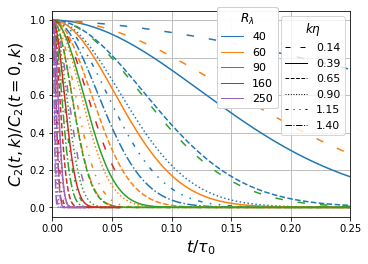

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(5,3.5))
for i in list(range(len(data_set))) :
    simu = data_set[i]
    data_dict=simu['corr']
    
    for iik in range(len(simu['indices_of_k_to_plot2'])) :
        ik = simu['indices_of_k_to_plot2'][iik]
        ax.plot(data_dict['time']/simu['t0'], data_dict['data'][:,ik] / data_dict['data'][0,ik], color=colors[i], linestyle=linestyles[iik])
ax.set(xscale='linear',yscale='linear', xlabel=r'$t/\tau_0$')
ax.set(xlim=[0,0.25])
ax.set(ylabel=r'$C_2(t,k) / C_2(t=0,k)$')
ax.grid(True)
legend1 = plt.legend([Line2D([0], [0], lw=1, linestyle=ls, color="black") for ls in linestyles], ["%2.2f" % (simu['k'][ik]*simu['eta']) for ik in simu['indices_of_k_to_plot2']], \
                     loc='upper right', title=r'$k\eta$', title_fontsize=12)
legend2 = plt.legend([Line2D([0], [0], lw=1, linestyle='-', color=ci) for ci in colors], [simu['Rl'] for simu in data_set], loc='best', title=r'$R_\lambda$', title_fontsize=12, \
                    bbox_to_anchor=(0.275, 0.5, 0.5, 0.5))
ax.add_artist(legend1)
ax.add_artist(legend2)
# pp = PdfPages('/home/gorbunov8a/Python/Images/Paper/2pcorrVSt.pdf')
# pp.savefig()
# pp.close()

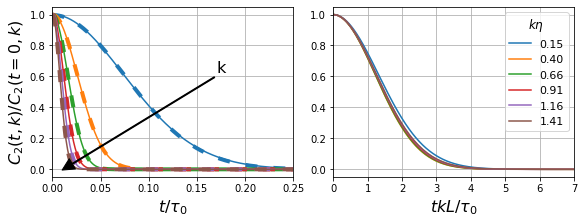

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=2,constrained_layout=True,figsize=(8,3))
simu = data_set[2] # data set for Rl=160, N=512
#header = fig.suptitle(r'Two-point spatio-temporal correlation function $C_2(t,k) = \left< \hat{u}_j(t_0, k) \hat{u}_j^* (t _0 + t, k)\right>$', size=18) 
data_dict=simu['corr']
x = data_dict['time']/simu['t0']
for i in range(len(simu['indices_of_k_to_plot2'][::])) :
    ik = simu['indices_of_k_to_plot2'][i]
    ax[0].plot(x, data_dict['data'][:,ik] / data_dict['data'][0,ik], '-')
    ax[0].plot(x, data_dict['fit_func'](x, *data_dict['fit_coef'][ik,:]), ls=(0, (3, 4)), linewidth=4, color=colors[i])
    ax[1].plot(data_dict['time']*simu['k'][ik]*simu['urms'], data_dict['data'][:,ik] / data_dict['data'][0,ik], color=colors[i], label=r'%2.2f' % (simu['k'][ik]*simu['eta']))
ax[0].set(xscale='linear',yscale='linear', xlabel=r'$t/\tau_0$', title=None); ax[0].grid()
ax[0].set(xlim=[0,0.25]); ax[0].set(ylabel=r'$C_2(t,k) / C_2(t=0,k)$')
ax[0].annotate('k', xy=(0.01, -0.005),  xycoords='data', xytext=(0.18, 0.7), textcoords='data', arrowprops=dict(facecolor='black', width=1), \
               size='16', horizontalalignment='right', verticalalignment='top')
ax[1].set(xscale='linear',yscale='linear', xlabel=r'$t k L/\tau_0$', title=None); ax[1].grid()
ax[1].set(xlim=[0,7])
lgd = ax[1].legend(loc='best', title=r'$k\eta$', title_fontsize=12)
#plt.show()

# pp = PdfPages('/home/gorbunov8a/Documents/Latex/tex_correlations/figures/2pcorr.pdf')
# pp.savefig()
# pp.close()

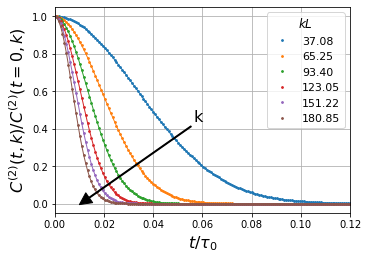

In [47]:
fig, ax = plt.subplots(nrows=1, ncols=1,constrained_layout=True,figsize=(5,3.5))
simu = data_set[2] # data set for Rl=160, N=512
#header = fig.suptitle(r'Two-point spatio-temporal correlation function $C_2(t,k) = \left< \hat{u}_j(t_0, k) \hat{u}_j^* (t _0 + t, k)\right>$', size=18) 
data_dict=simu['corr']
x = data_dict['time']/simu['t0']
for i in range(len(simu['indices_of_k_to_plot'][:])) :
    ik = simu['indices_of_k_to_plot'][i]
    ax.plot(x, data_dict['data'][:,ik] / data_dict['data'][0,ik], '.', color=colors[i], markersize=3.5, label=r'%2.2f' % (simu['k'][ik]*simu['L']))
    ax.plot(x, data_dict['fit_func'](x, *data_dict['fit_coef'][ik,:]), linewidth=1, color=colors[i]) #ls=(0, (3, 5)), 
ax.set(xscale='linear',yscale='linear', xlabel=r'$t/\tau_0$', title=None); ax.grid()
ax.set(xlim=[0,0.12]); ax.set(ylabel=r'$C^{(2)}(t,k) / C^{(2)}(t=0,k)$')
ax.annotate('k', xy=(0.01, -0.005),  xycoords='data', xytext=(0.06, 0.5), textcoords='data', arrowprops=dict(facecolor='black', width=1), size='16', horizontalalignment='right', verticalalignment='top')
lgd = ax.legend(loc='best', title=r'$kL$', title_fontsize=12)
#get_plot_data(ax,'fig32a.dat')
# pp = PdfPages('../Images/Paper/2pcorrVSt.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()

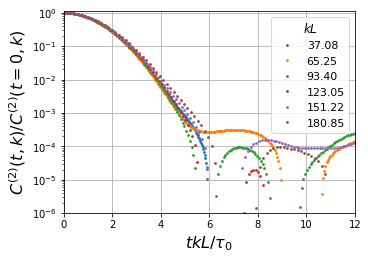

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=1,constrained_layout=True,figsize=(5,3.5))
simu = data_set[2] # data set for Rl=160, N=512
#header = fig.suptitle(r'Two-point spatio-temporal correlation function $C_2(t,k) = \left< \hat{u}_j(t_0, k) \hat{u}_j^* (t _0 + t, k)\right>$', size=18) 
data_dict=simu['corr']
x = data_dict['time']/simu['t0']
for i in range(len(simu['indices_of_k_to_plot'][:])) :
    ik = simu['indices_of_k_to_plot'][i]
    ax.plot(x*simu['k'][ik]*simu['L'], data_dict['data'][:,ik] / data_dict['data'][0,ik], '.', color=colors[i], markersize=3.5, label=r'%2.2f' % (simu['k'][ik]*simu['L']))
    #ax.plot(x*simu['k'][ik]*simu['L'], data_dict['fit_func'](x, *data_dict['fit_coef'][ik,:]), linewidth=1, color=colors[i]) #ls=(0, (3, 5)), 
ax.set(xscale='linear',yscale='log', xlabel=r'$t kL/\tau_0$', title=None); ax.grid()
ax.set(xlim=[0,12.0]); ax.set(ylabel=r'$C^{(2)}(t,k) / C^{(2)}(t=0,k)$')
ax.set(ylim=[1e-6,1.1])
lgd = ax.legend(loc='best', title=r'$kL$', title_fontsize=12)
#get_plot_data_blocks(ax,'fig32b_k=')
# pp = PdfPages('/home/gorbunov8a/Documents/Latex/these/Figures/2pcorrVStk.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()

## Decorrelation time

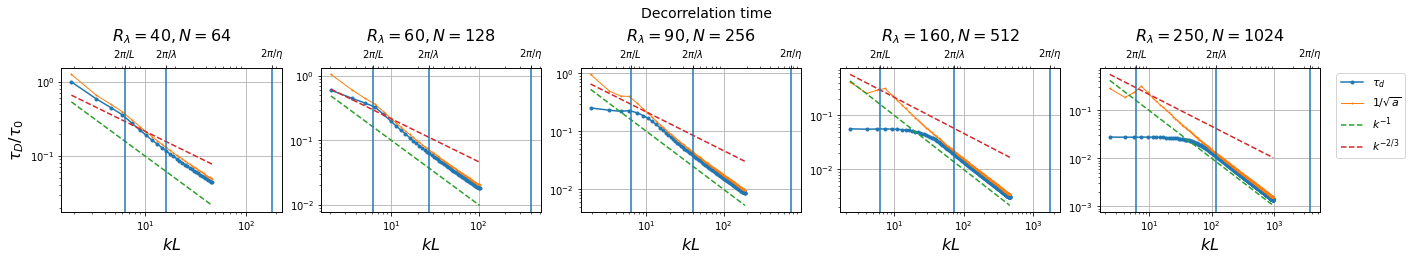

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=len(data_set), constrained_layout=True,figsize=(3.5*len(data_set)+2,3.5))
fig.suptitle(r'Decorrelation time', size=14) 
for i in list(range(len(data_set))) :
    simu = data_set[i]
    data_dict=simu['corr']
    data_dict.update({'integral_decorrelation_time' : np.ndarray(shape=(len(simu['k']),1), dtype=float)}) #allocate
    for ik in list(range(len(simu['k']))) : 
        data_dict['integral_decorrelation_time'][ik] = np.trapz(data_dict['data'][:,ik] / data_dict['data'][0,ik], x=data_dict['time'])
    x = simu['k']*simu['L']
    ax[i].plot(x, data_dict['integral_decorrelation_time'][::]/simu['t0'], '.-', label=r'$\tau_d$')
    ax[i].plot(x, 1.0/np.sqrt(data_dict['fit_coef'][:,0]), '.-', label=r'$1/\sqrt{a}$', lw=1.0, markersize=2.0)
    ax[i].plot(x, x**(-1.0), '--', label=r'$k^{-1}$')
    ax[i].plot(x, x**(-2.0/3.0), '--', label=r'$k^{-2/3}$')
    
    ax[i].set(xscale='log',yscale='log', xlabel=r'$kL$', title=simu['legend']); ax[i].grid()
    #ax[i].set(ylim=[0,1.5])
    if (i == 0) : ax[i].set(ylabel=r'$\tau_D / \tau_0$')
    # plot spatial scales
    vertical_lines = 2.0*np.pi/simu['spatial_scales']*simu['L']
    for line in vertical_lines : ax[i].axvline(x=line)     
    ax2 = ax[i].twiny(); ax2.set(xscale=ax[i].get_xscale(), yscale=ax[i].get_yscale(), xlim = ax[i].get_xlim())
    ax2.set_xticks(vertical_lines); ax2.set_xticklabels([r'$2\pi/L$', r'$2\pi/\lambda$', r'$2\pi/\eta$'])
    if (i == len(data_set)-1) : lgd = ax[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

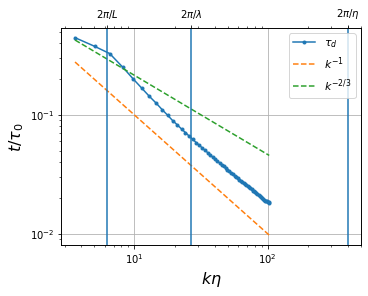

In [50]:
#integral decorrelation time of C2
simu = data_set[1]
data_dict=simu['corr']
ik_min_decorr = np.transpose(np.nonzero(data_dict['data'][:,:]<1e-9))[0,0] #minimal k at which C2 is fully decorrelated (important in case of small time windows) 
ik_min_decorr = 1
data_dict.update({'integral_decorrelation_time' : np.ndarray(shape=(len(simu['k']),1), dtype=float)}) #allocate
for ik in list(range(len(simu['k']))) : 
    data_dict['integral_decorrelation_time'][ik] = np.trapz(data_dict['data'][:,ik] / data_dict['data'][0,ik], x=data_dict['time'])

fig, ax = plt.subplots(nrows=1, ncols=1,constrained_layout=True,figsize=(5,4))
x = simu['k'][ik_min_decorr::]*simu['L']
ax.plot(simu['k'][ik_min_decorr::]*simu['L'], data_dict['integral_decorrelation_time'][ik_min_decorr::]/simu['t0'], '.-', label=r'$\tau_d$')
ax.plot(simu['k'][ik_min_decorr::]*simu['L'], x**(-1.0), '--', label=r'$k^{-1}$')
ax.plot(simu['k'][ik_min_decorr::]*simu['L'], x**(-2.0/3.0), '--', label=r'$k^{-2/3}$')
#ax.plot(x, np.full_like(x, simu['t0']))
ax.set(xscale='log', yscale='log', xlabel=r'$k\eta$', ylabel=r'$t/\tau_0$'); ax.grid()
#ax.set(xlim=[0.02,2.0])

#ax.axvspan(0, simu['filter_cut_off_k']*simu['k_norm'], facecolor='red', alpha=0.15, label='Filtered out modes')
#plot spatial scales
vertical_lines = 2.0*np.pi/simu['spatial_scales']*simu['L']
for line in vertical_lines[:] : ax.axvline(x=line)     
ax2 = ax.twiny(); ax2.set(xscale=ax.get_xscale(), yscale=ax.get_yscale(), xlim = ax.get_xlim())
ax2.set_xticks(vertical_lines[:]); ax2.set_xticklabels([r'$2\pi/L$', r'$2\pi/\lambda$', r'$2\pi/\eta$'])
lgd = ax.legend(loc='best')
#plt.show()
# pp = PdfPages('/home/gorbunov8a/Documents/Latex/tex_correlations/figures/2pcorr_decorr_time_1Re.pdf')
# pp.savefig(bbox_inches='tight')
# pp.close()

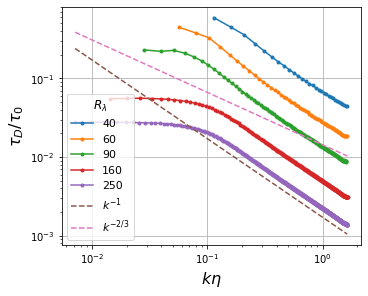

In [51]:
#integral decorrelation time of C2
fig, ax = plt.subplots(nrows=1, ncols=1,constrained_layout=True,figsize=(5,4))
for i in list(range(len(data_set))) :
    simu = data_set[i]
    data_dict=simu['corr']
    #ik_min_decorr = np.transpose(np.nonzero(data_dict['data'][:,:]<1e-9))[0,0] #minimal k at which C2 is fully decorrelated (important in case of small time windows) 
    ik_min_decorr = 1
    data_dict.update({'integral_decorrelation_time' : np.ndarray(shape=(len(simu['k']),1), dtype=float)}) #allocate
    for ik in list(range(len(simu['k']))) : 
        data_dict['integral_decorrelation_time'][ik] = np.trapz(data_dict['data'][:,ik] / data_dict['data'][0,ik], x=data_dict['time'])
    x = simu['k'][ik_min_decorr::]*simu['L']
    ax.plot(simu['k'][ik_min_decorr::]*simu['eta'], data_dict['integral_decorrelation_time'][ik_min_decorr::]/simu['t0'], '.-', \
           label=simu['Rl'])
ax.plot(simu['k'][ik_min_decorr::]*simu['eta'], x**(-1.0), '--', label=r'$k^{-1}$')
ax.plot(simu['k'][ik_min_decorr::]*simu['eta'], x**(-2.0/3.0), '--', label=r'$k^{-2/3}$')
#     ax.plot(simu['k'][ik_min_decorr::]*simu['eta'], x**(-1.0), '--', label=r'$k^{-1}$')
#     ax.plot(simu['k'][ik_min_decorr::]*simu['eta'], x**(-2.0/3.0), '--', label=r'$k^{-2/3}$')
#ax.plot(x, np.full_like(x, simu['t0']))
ax.set(xscale='log', yscale='log', xlabel=r'$k\eta$', ylabel=r'$\tau_D/\tau_0$'); ax.grid()
#ax.set(xlim=[0.01,2.0])
lgd = ax.legend(loc='best',title=r'$R_\lambda$', title_fontsize=12)
#plt.show()
# pp = PdfPages('/home/gorbunov8a/Documents/Latex/tex_correlations/figures/2pcorrdecorrtimeallReketa.pdf')
# pp.savefig(bbox_inches='tight')
# pp.close()

## Fitting params

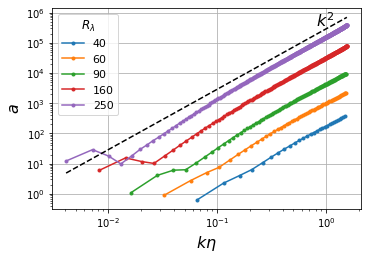

In [52]:
# results of fit
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(5,3.5))
for i in list(range(len(data_set))) :
    simu = data_set[i]
    ik_min_decorr = np.transpose(np.nonzero(simu['corr']['data'][:,:]<10e-9))[0,0]
    ik1 = ik_min_decorr
    indices = slice(ik1,simu['ik_max'])
    #normalization = 1.0/(simu['L']**2.0)
    normalization = 1.0
    dictionary = simu['corr']
    ax.plot(simu['k'][indices]*simu['eta'], np.abs(dictionary['fit_coef'][indices,0])*normalization, '.-', label=simu['Rl'])
#ax.annotate(r'$R_\lambda$', xy=(1.8, 1e6),  xycoords='data', xytext=(1.8, 1e3), textcoords='data', arrowprops=dict(facecolor='black', width=2), size=16,horizontalalignment='center', verticalalignment='top')
ax.plot(simu['k'][indices]*simu['eta'], 0.3e1*(simu['k'][indices])**2.0, 'k--')
ax.annotate(r'$k^2$', xy=(0.8, 3.5e5), xycoords='data', size='16')
ax.set(xscale='log', yscale='log', xlabel=r'$k\eta$',ylabel=r'$a$'); ax.grid()
#ax.set(xlim=[0.015,2.0])
#ax.set(xlim=[5,1e3]); ax.set(ylim=[1,10e5])
lgd = ax.legend(loc='best',title=r'$R_\lambda$', title_fontsize=12)
# pp = PdfPages('Images/Correlations/2pcorrfitavskL2.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()

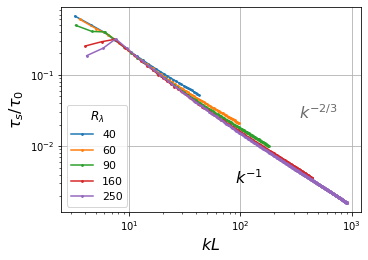

In [53]:
# results of fit
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(5,3.5))
for i in list(range(len(data_set))) :
    simu = data_set[i]
    ik_min_decorr = np.transpose(np.nonzero(simu['corr']['data'][:,:]<10e-9))[0,0]
    ik1 = ik_min_decorr
    indices = slice(1,simu['ik_max'])
    #normalization = 1.0/(simu['L']**2.0)
    normalization = 1.0
    dictionary = simu['corr']
    x = simu['k'][indices]*simu['L']
    ax.plot(x, 1.0/np.sqrt(dictionary['fit_coef'][indices,0]), '.-', label=simu['Rl'], markersize=3.5)
ax.annotate(r'$k^{-1}$', xy=(120, 5e-3),  xycoords='data', size=16, horizontalalignment='center', verticalalignment='top')
ax.annotate(r'$k^{-2/3}$', xy=(500, 4e-2),  xycoords='data', color='dimgray', size=16, horizontalalignment='center', verticalalignment='top')
# ax.plot(x, (x)**(-1), 'k--')
# ax.plot(x, (x)**(-2.0/3.0), '--', color='dimgray')
#ax.annotate(r'$k^2$', xy=(0.8, 3.5e5), xycoords='data', size='16')
ax.set(xscale='log', yscale='log', xlabel=r'$kL$',ylabel=r'$\tau_s/\tau_0$'); ax.grid()
#ax.set(xlim=[0.015,2.0])
#ax.set(xlim=[5,1e3]); ax.set(ylim=[1,10e5])
lgd = ax.legend(loc='lower left',title=r'$R_\lambda$', title_fontsize=12)
#get_plot_data_blocks(ax,'fig33a')
# pp = PdfPages('/home/gorbunov8a/Python/Images/Paper/tauSvsKL.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()

/tmp/ipykernel_22998/645708833.py:17: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(xlim=[0,1100])


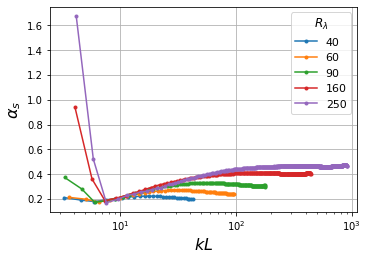

In [54]:
# results of fit
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(5,3.5))
for simu in data_set[:] :
    ik_min_decorr = np.transpose(np.nonzero(simu['corr']['data'][:,:]<10e-9))[0,0]
    ik1 = 1
    indices = slice(ik1,simu['ik_max'])
    normalization = 1.0/((simu['k'][indices]*simu['L'])**2.0)
    #normalization = 1.0
    dictionary = simu['corr']
    #ax.plot(simu['k'][indices]*simu['L'], np.abs(dictionary['fit_coef'][indices,0])*normalization, '.-', label=simu['Rl'], color=colors[i])
    ax.plot(simu['k'][indices]*simu['L'], dictionary['fit_coef'][indices,0]*normalization, '.-', label=simu['Rl'])
    #ax.plot(simu['k'][indices]*simu['L'], dictionary['exp_width'][indices,0], '.-', label=simu['Rl'], color=colors[i])
#ax.annotate(r'$R_\lambda$', xy=(1.8, 1e6),  xycoords='data', xytext=(1.8, 1e3), textcoords='data', arrowprops=dict(facecolor='black', width=2), size=16,horizontalalignment='center', verticalalignment='top')
#ax.plot(simu['k'][indices]*simu['eta'], 1e1*(simu['k'][indices])**2.0, 'k--', label=r'$k^2$')
#ax.annotate(r'$k^2$', xy=(1.15, 1.6e6), xycoords='data', size='16')
ax.set(xscale='log', yscale='linear', xlabel=r'$kL$',ylabel=r'$\alpha_s$'); ax.grid()
ax.set(xlim=[0,1100])
lgd = ax.legend(loc='best', title=r'$R_\lambda$', title_fontsize=12)
#get_plot_data_blocks(ax,'fig33b')
# pp = PdfPages('/home/gorbunov8a/Python/Images/Paper/2pcorrfitak2vskL.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()

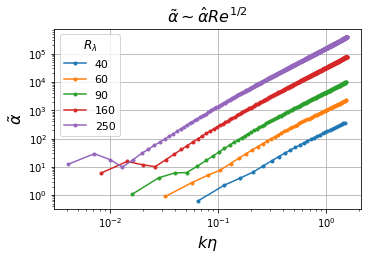

In [55]:
# results of fit
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(5,3.5))
for simu in data_set :
    ik_min_decorr = np.transpose(np.nonzero(simu['corr']['data'][:,:]<10e-9))[0,0]
    ik1 = ik_min_decorr
    indices = slice(ik1,simu['ik_max'])
    #normalization = 1.0/((simu['k'][indices]*simu['L'])**2.0)
    normalization = 1.0
    dictionary = simu['corr']
    ax.plot(simu['k'][indices]*simu['eta'], dictionary['fit_coef'][indices,0]*normalization, '.-', label=simu['Rl'])
#ax.annotate(r'$R_\lambda$', xy=(1.8, 1e6),  xycoords='data', xytext=(1.8, 1e3), textcoords='data', arrowprops=dict(facecolor='black', width=2), size=16,horizontalalignment='center', verticalalignment='top')
#ax.plot(simu['k'][indices]*simu['eta'], 1e1*(simu['k'][indices])**2.0, 'k--', label=r'$k^2$')
#ax.annotate(r'$k^2$', xy=(1.15, 1.6e6), xycoords='data', size='16')
ax.set(xscale='log', yscale='log', xlabel=r'$k\eta$',ylabel=r'$\tilde{\alpha}$', title=r'$\tilde{\alpha} \sim \hat{\alpha} Re^{1/2}$'); ax.grid()
#ax.set(ylim=[0,40])
lgd = ax.legend(loc='best', title=r'$R_\lambda$', title_fontsize=12)
# pp = PdfPages('/home/gorbunov8a/Documents/Latex/tex_correlations/figures/2pcorrfitak2vskL.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()

In [56]:
# # results of fit
# fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(5,3.5))
# for i in list(range(len(data_set))) :
#     simu = data_set[i]
#     ik_min_decorr = np.transpose(np.nonzero(simu['corr']['data'][:,:]<10e-9))[0,0]
#     ik1 = ik_min_decorr
#     indices = slice(ik1,simu['ik_max'])
#     normalization = 1.0/((simu['k'][indices]*simu['L'])**2.0)
#     #normalization = 1.0
#     dictionary = simu['corr']
#     ax.plot(simu['k'][indices]*simu['L'], np.abs(dictionary['fit_coef'][indices,0] - dictionary['fit_coef'][indices,0]), '-.', label=simu['Rl'], color=colors[i])
# #ax.annotate(r'$R_\lambda$', xy=(1.8, 1e6),  xycoords='data', xytext=(1.8, 1e3), textcoords='data', arrowprops=dict(facecolor='black', width=2), size=16,horizontalalignment='center', verticalalignment='top')
# #ax.plot(simu['k'][indices]*simu['eta'], 1e1*(simu['k'][indices])**2.0, 'k--', label=r'$k^2$')
# #ax.annotate(r'$k^2$', xy=(1.15, 1.6e6), xycoords='data', size='16')
# ax.set(xscale='log', yscale='log', xlabel=r'$kL$',ylabel=r'$\alpha_s$', title='Difference between fits'); ax.grid()
# #ax.set(xlim=[0.015,2.0])
# #ax.set(xlim=[5,2.10e3])
# #ax.set(ylim=[0.04,0.17])
# lgd = ax.legend(loc='best', title=r'$R_\lambda$', title_fontsize=12)
# # pp = PdfPages('/home/gorbunov8a/Documents/Latex/tex_correlations/figures/2pcorrfitak2vskL.pdf')
# # pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# # pp.close()

## Fitting error

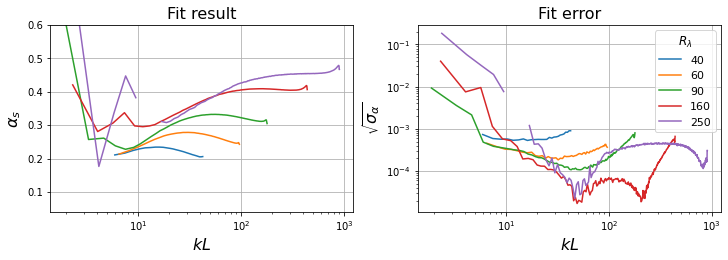

In [57]:
# stds of fit
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True,figsize=(10,3.5))
for i in list(range(len(data_set))) :
    simu = data_set[i]
    ik_min_decorr = np.transpose(np.nonzero(simu['corr']['data'][:,:]<10e-9))[0,0]
    ik1 = ik_min_decorr
    indices = slice(ik1,simu['ik_max'])
    normalization = 1.0/((simu['k'][indices]*simu['L'])**2.0)
    #normalization = 1.0
    dictionary = simu['t_total']
    ax[0].plot(simu['k'][indices]*simu['L'], np.abs(dictionary['fit_coef'][indices,0])*normalization, '-', label=simu['Rl'], color=colors[i])
    #ax[0].plot(simu['k'][indices]*simu['L'], dictionary['fit_coef_tk'][indices,0], '--', label=simu['Rl'], color=colors[i])
    ax[1].plot(simu['k'][indices]*simu['L'], dictionary['perr'][indices,0]*normalization, '-', color=colors[i], label=simu['Rl'])
    #ax[1].plot(simu['k'][indices]*simu['L'], dictionary['perr_tk'][indices,0], '--', color=colors[i])
ax[0].set(xscale='log', yscale='linear', xlabel=r'$kL$',ylabel=r'$\alpha_s$', title='Fit result'); ax[0].grid()
ax[0].set(ylim=[0.04,0.60])
ax[1].set(xscale='log', yscale='log', xlabel=r'$kL$',ylabel=r'$\sqrt{\sigma_\alpha}$', title='Fit error'); ax[1].grid()
lgd = ax[1].legend(loc='best', title=r'$R_\lambda$', title_fontsize=12)

## Fit parameters vs Rl

In [58]:
# for i in list(range(len(data_set))) :
#     simu = data_set[i]
#     for dictionary in [simu['t_total'],simu['t_sls'], simu['corr'], simu['t_sss']] : 
#         indices = slice(simu['ik2f'],simu['ik_max'])
#         data = dictionary['fit_coef'][indices,0]/((simu['k'][indices]*simu['L'])**2.0)
#         dictionary['plateau_params_alphas'] = dictionary['plateau_params_alphas']
#         dictionary['plateau_params_b'] = find_plateau(dictionary['fit_coef'][indices,1])

In [59]:
# fig, ax = plt.subplots(constrained_layout=True, nrows=1, ncols=1, figsize=(5,3.5))
# x = [simu['Rl'] for simu in data_set]

# #ax.plot(x, [simu['t_total']['plateau_params_alphas'][0] for simu in data_set], '-o', label=r'$\hat{T}$')
# #ax.plot(x, [simu['t_sss']['plateau_params_alphas'][0] for simu in data_set], '-o', label=r'$\hat{T}^{filter}$')
# ax.plot(x, [simu['corr']['plateau_params_alphas'][0] for simu in data_set], '-o', label=r'$C^{(2)}$')
# #ax.plot(x, 0.035*np.sqrt(x), 'k--', label=r'$\sim \sqrt{R_\lambda}$')
# ax.set(xlabel=r'$R_\lambda$', ylabel=r'$\alpha_s$', xscale='linear', yscale='linear'); ax.grid()
# #lgd = ax.legend(loc='best')
# # pp = PdfPages('/home/gorbunov8a/Documents/Latex/these/Figures/alpha_vs_Re.pdf')
# # pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# # pp.close()
# plt.show()

## Plots for T

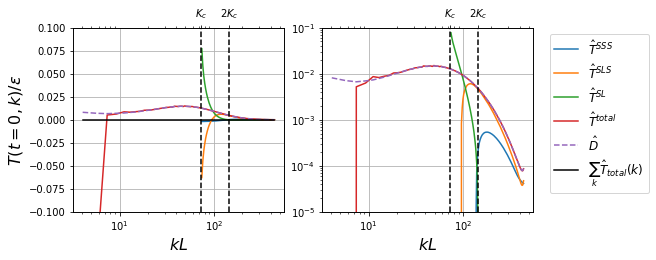

In [60]:
fig, axises = plt.subplots(nrows=1, ncols=2, constrained_layout=True,figsize=(9,3.5))
i = 3
simu = data_set[i]
it = len(data_set[i]['t_total']['time'])//2
norm_coef = 1.0/simu['dissip_rate']


for ax in axises : 
    indices = slice(simu['filter_cut_off_k'],simu['ik_max'])
    for dictionary in [simu['t_sss'], simu['t_sls'], simu['t_sl']] : 
        ax.plot(simu['k'][indices]*simu['L'], dictionary['data'][it,indices]*simu['spher_coef'][indices]*norm_coef, '-', label=dictionary['legend'])
    indices = slice(1,simu['ik_max'])
    ax.plot(simu['k'][indices]*simu['L'], simu['t_total']['data'][it,indices]*simu['spher_coef'][indices]*norm_coef, '-', label=simu['t_total']['legend'])
    ax.plot(simu['k'][indices]*simu['L'], simu['dissipation_spec'][indices]*simu['spher_coef'][indices]*norm_coef, '--', label=r'$\hat{D}$')
    ax.plot(simu['k'][indices]*simu['L'], np.full_like(simu['k'][indices], np.sum(simu['t_total']['data'][it,::]))*norm_coef, '-', color='black', label=r'$\sum_k \hat{T}_{total}(k)$ ')
    ax.set(xscale='log',xlabel=r'$kL$'); ax.grid()
    # show the range of the filtered out wavenumbers
    # ax.axvspan(0, simu['filter_cut_off_k']*simu['L'], facecolor='purple', alpha=0.15, label='Large scales')
    # ax.axvspan(simu['filter_cut_off_k']*simu['L'],simu['k'][-1]*simu['L'], facecolor='green', alpha=0.15, label='Small scales')
    # plot spatial scales
    vertical_lines = [simu['filter_cut_off_k']*simu['L'], 2.*simu['filter_cut_off_k']*simu['L']]
    for line in vertical_lines : ax.axvline(x=line, ls='--', color='k')     
    ax2 = ax.twiny(); ax2.set(xscale=ax.get_xscale(), yscale=ax.get_yscale(), xlim = ax.get_xlim())
    ax2.set_xticks(vertical_lines); ax2.set_xticklabels([r'$K_c$', r'$2 K_c$'])

axises[0].set(ylim=[-0.1,0.1], ylabel=r'$T(t=0,k) / \epsilon$', yscale='linear')
axises[1].set(ylim=[1e-5,0.1], yscale='log')
lgd = axises[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

# pp = PdfPages('/home/gorbunov8a/Documents/Latex/these/Figures/transfers_filtered.pdf')
# pp.savefig()
# pp.close()

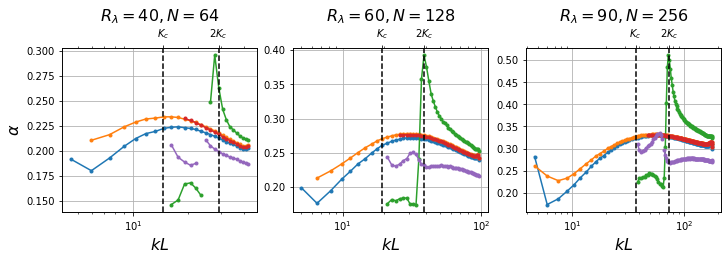

In [61]:
fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=True,figsize=(10,3.5), )
#fig.suptitle(r'Fitting result: $\alpha_s = a/(kL)^2$', size=14) 
for i in range(3) :
    simu = data_set[i]
    indices = slice(2,simu['ik_max'])
    x = simu['k']*simu['L']
    for dictionary in [simu['corr'], simu['t_total']] :
        ax[i].plot(x[indices], np.abs(dictionary['fit_coef'][indices,0]/((simu['k'][indices]*simu['L'])**2.0)), '.-', label=dictionary['legend'])
    indices = slice(simu['filter_cut_off_k'],simu['ik_max'])
    for dictionary in [simu['t_sss'], simu['t_sls'], simu['t_sl']] : 
        ax[i].plot(x[indices], np.abs(dictionary['fit_coef'][indices,0]/((simu['k'][indices]*simu['L'])**2.0)), '.-', label=dictionary['legend'])
    #error_dict=simu['t_total']
    #ax[i].errorbar(simu['k'][indices], error_dict['fit_coef'][indices,0]*normalization, yerr=error_dict['fit_cov_matrix'][indices,0,0]*normalization)
    ax[i].set(xscale='log', yscale='linear', xlabel=r'$kL$', title=simu['legend']); ax[i].grid()
    #ax[i].set(ylim=[0.05,0.25])
    if (i == 0) : ax[i].set(ylabel=r'$\alpha$')
    # show the range of the filtered out wavenumbers
    vertical_lines = [simu['filter_cut_off_k']*simu['L'], 2.*simu['filter_cut_off_k']*simu['L']]
    for line in vertical_lines : ax[i].axvline(x=line, ls='--', color='k')     
    ax2 = ax[i].twiny(); ax2.set(xscale=ax[i].get_xscale(), yscale=ax[i].get_yscale(), xlim = ax[i].get_xlim())
    ax2.set_xticks(vertical_lines); ax2.set_xticklabels([r'$K_c$', r'$2 K_c$'])
#lgd = ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
# pp = PdfPages('/home/gorbunov8a/Documents/Latex/these/Figures/transfers_filtered_fit1.pdf')
# pp.savefig()
# pp.close()

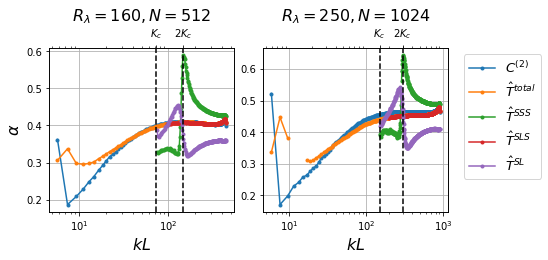

In [62]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True,figsize=(7.5,3.5), )
#fig.suptitle(r'Fitting result: $\alpha_s = a/(kL)^2$', size=14) 
for i in range(2) :
    simu = data_set[i+3]
    indices = slice(2,simu['ik_max'])
    x = simu['k']*simu['L']
    for dictionary in [simu['corr'], simu['t_total']] :
        ax[i].plot(x[indices], np.abs(dictionary['fit_coef'][indices,0]/((simu['k'][indices]*simu['L'])**2.0)), '.-', label=dictionary['legend'])
    indices = slice(simu['filter_cut_off_k'],simu['ik_max'])
    for dictionary in [simu['t_sss'], simu['t_sls'], simu['t_sl']] : 
        ax[i].plot(x[indices], np.abs(dictionary['fit_coef'][indices,0]/((simu['k'][indices]*simu['L'])**2.0)), '.-', label=dictionary['legend'])
    #error_dict=simu['t_total']
    #ax[i].errorbar(simu['k'][indices], error_dict['fit_coef'][indices,0]*normalization, yerr=error_dict['fit_cov_matrix'][indices,0,0]*normalization)
    ax[i].set(xscale='log', yscale='linear', xlabel=r'$kL$', title=simu['legend']); ax[i].grid()
    #ax[i].set(ylim=[0.05,0.25])
    if (i == 0) : ax[i].set(ylabel=r'$\alpha$')
    # show the range of the filtered out wavenumbers
    vertical_lines = [simu['filter_cut_off_k']*simu['L'], 2.*simu['filter_cut_off_k']*simu['L']]
    for line in vertical_lines : ax[i].axvline(x=line, ls='--', color='k')     
    ax2 = ax[i].twiny(); ax2.set(xscale=ax[i].get_xscale(), yscale=ax[i].get_yscale(), xlim = ax[i].get_xlim())
    ax2.set_xticks(vertical_lines); ax2.set_xticklabels([r'$K_c$', r'$2 K_c$'])
lgd = ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=13)
# pp = PdfPages('/home/gorbunov8a/Documents/Latex/these/Figures/transfers_filtered_fit2.pdf')
# pp.savefig()
# pp.close()

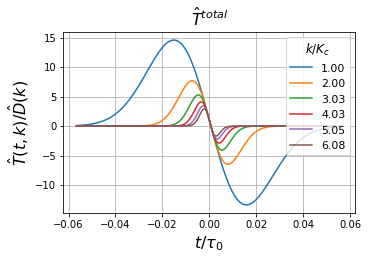

In [63]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(5,3.5))
#fig.suptitle(r'Total advection-velocity correlation $T_{total}(t,k) = -\Re \left< \hat{N}_j(t_0 + t, k) \hat{u}_j^* (t _0, k)\right>$', size=14) 
i=3
simu = data_set[i]
data_dict0=simu['t_total']
data_dict1=simu['t_sss']
for ik in simu['indices_of_k_to_plot'] :
    ax.plot(data_dict0['time']/simu['t0'], data_dict0['data'][:,ik] / simu['dissipation_spec'][ik], '-', label=r'%2.2f' % (simu['k'][ik]/simu['filter_cut_off_k']))
ax.set(xscale='linear',yscale='linear', xlabel=r'$t/\tau_0$', title=r'$\hat{T}^{total}$'); ax.grid()
#ax[0].set(xlim=[-0.95,0.95]); 
ax.set(ylabel=r'$\hat{T}(t,k) / \hat{D}(k)$')
lgd = ax.legend(loc='upper right', title=r'$k/K_c$', title_fontsize=12)
#pp = PdfPages('/home/gorbunov8a/python_process_notebooks/Images/Paper/TvstNonFiltered.pdf')
#pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
#pp.close()

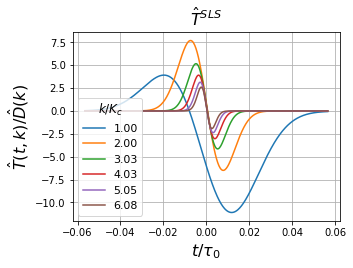

In [64]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(4.75,3.5))
#fig.suptitle(r'Total advection-velocity correlation $T_{total}(t,k) = -\Re \left< \hat{N}_j(t_0 + t, k) \hat{u}_j^* (t _0, k)\right>$', size=14) 
i=3
simu = data_set[i]
data_dict1=simu['t_sls']
for iik,ik in enumerate(simu['indices_of_k_to_plot'][::]) :
    ax.plot(data_dict1['time']/simu['t0'], data_dict1['data'][:,ik] / simu['dissipation_spec'][ik], '-', label=r'%2.2f' % (simu['k'][ik]/simu['filter_cut_off_k']), color=colors[iik])
#ax.set(ylabel=r'$T(t,k) / D(k)$')
ax.set(xscale='linear',yscale='linear', xlabel=r'$t/\tau_0$', title=r'$\hat{T}^{SLS}$'); ax.grid()
ax.set(ylabel=r'$\hat{T}(t,k) / \hat{D}(k)$')
lgd = ax.legend(loc='lower left', title=r'$k/K_c$', title_fontsize=12)
pp = PdfPages('/home/gorbunov8a/Documents/Latex/these/Figures/TSLS.pdf')
pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
pp.close()

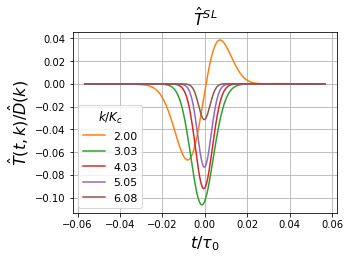

In [65]:
#compare with t_total
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(4.75,3.5))
#fig.suptitle(r'Total advection-velocity correlation $T_{total}(t,k) = -\Re \left< \hat{N}_j(t_0 + t, k) \hat{u}_j^* (t _0, k)\right>$', size=14) 
i=3
simu = data_set[i]
data_dict1=simu['t_sl']
for iik,ik in enumerate(simu['indices_of_k_to_plot'][1::]) :
    ax.plot(data_dict1['time']/simu['t0'], data_dict1['data'][:,ik] / simu['dissipation_spec'][ik], '-', label=r'%2.2f' % (simu['k'][ik]/simu['filter_cut_off_k']), color=colors[iik+1])
#ax.set(ylabel=r'$T(t,k) / D(k)$')
ax.set(xscale='linear',yscale='linear', xlabel=r'$t/\tau_0$', title=r'$\hat{T}^{SL}$'); ax.grid()
ax.set(ylabel=r'$\hat{T}(t,k) / \hat{D}(k)$')
lgd = ax.legend(loc='lower left', title=r'$k/K_c$', title_fontsize=12)
# pp = PdfPages('/home/gorbunov8a/Documents/Latex/these/Figures/TSL.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()

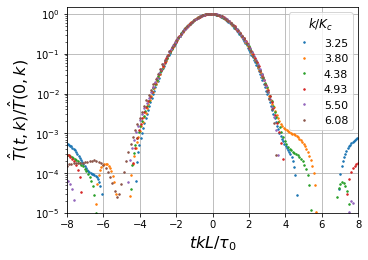

In [66]:
# check tk scaling
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(5,3.5))
#fig.suptitle(r'Total advection-velocity correlation $T_{total}(t,k) = -\Re \left< \hat{N}_j(t_0 + t, k) \hat{u}_j^* (t _0, k)\right>$', size=14) 
i=3
simu = data_set[i]
data_dict1=simu['t_sss']
it0 = len(data_dict1['time'])//2
for i in range(len(simu['indices_of_k_to_plot3'][4::])) :
    ik = simu['indices_of_k_to_plot3'][i+4]
    ax.plot(data_dict1['time']/simu['t0']*simu['k'][ik]*simu['L'], data_dict1['data'][:,ik] / data_dict1['data'][it0,ik], '.', color=colors[i], markersize=3.0, label=r'%2.2f' % (simu['k'][ik]/simu['filter_cut_off_k']))
    #ax.plot(data_dict1['time']/simu['t0']*simu['k'][ik]*simu['L'], data_dict1['fit_func'](data_dict1['time']/simu['t0'], *data_dict1['fit_coef'][ik,:])*simu['dissipation_spec'][ik]/data_dict1['data'][it0,ik], \
    #        linestyle='-', linewidth=1.0, color=colors[i], label=r'%2.2f' % (simu['k'][ik]/simu['filter_cut_off_k']))
ax.set(xscale='linear',yscale='log', xlabel=r'$t k L/\tau_0$'); ax.grid()
ax.set(xlim=[-8.0, 8.0]); ax.set(ylabel=r'$\hat{T}(t,k) / \hat{T}(0,k)$')
ax.set(ylim=[10e-6,1.5]); 
lgd = ax.legend(loc='upper right', title=r'$k/K_c$', title_fontsize=12)
#get_plot_data_blocks(ax,'fig39b_k=')
# pp = PdfPages('/home/gorbunov8a/Documents/Latex/these/Figures/Tfiltvstcollapse.pdf')
# pp.savefig()
# pp.close()

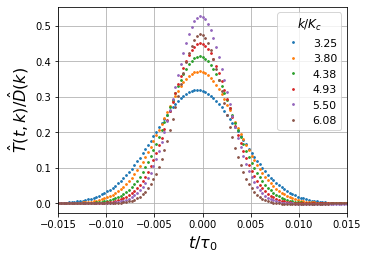

In [67]:
fig, ax = plt.subplots(nrows=1, ncols=1,constrained_layout=True,figsize=(5,3.5))
simu = data_set[3] # data set for Rl=160, N=512
#header = fig.suptitle(r'Two-point spatio-temporal correlation function $C_2(t,k) = \left< \hat{u}_j(t_0, k) \hat{u}_j^* (t _0 + t, k)\right>$', size=18) 
data_dict=simu['t_sss']
x = data_dict['time']/simu['t0']
it0 = len(data_dict1['time'])//2
for i in range(len(simu['indices_of_k_to_plot3'][4::])) :
    ik = simu['indices_of_k_to_plot3'][i+4]
    #if (i>3) :
    ax.plot(data_dict['time']/simu['t0'], data_dict['data'][:,ik] / simu['dissipation_spec'][ik], '.', color=colors[i], markersize=3.5, label=r'%2.2f' % (simu['k'][ik]/simu['filter_cut_off_k']))
    #ax.plot(data_dict['time']/simu['t0'], data_dict['fit_func'](x, *data_dict['fit_coef'][ik,:]), linewidth=1.5, color=colors[i], label=r'%2.2f' % (simu['k'][ik]/simu['filter_cut_off_k'])) #ls=(0, (3, 5)), 
ax.set(xscale='linear',yscale='linear', xlabel=r'$t/\tau_0$', title=None); ax.grid()
ax.set(xlim=[-0.015,0.015]); 
ax.set(ylabel=r'$\hat{T}(t,k) / \hat{D}(k)$')
#ax.annotate('k', xy=(0.05, -0.005),  xycoords='data', xytext=(0.4, 0.6), textcoords='data', arrowprops=dict(facecolor='black', width=1), size='16', horizontalalignment='right', verticalalignment='top')
lgd = ax.legend(loc='upper right', title=r'$k/K_c$', title_fontsize=12)
#get_plot_data(ax,'fig39a')
# pp = PdfPages('/home/gorbunov8a/Documents/Latex/these/Figures/TfiltFit.pdf')
# pp.savefig()
# pp.close()

In [ ]:
# results of fit
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(5,3.5))
for i in list(range(len(data_set))) :
    simu = data_set[i]
    ik1 = simu['ik2f']
    indices = np.s_[ik1:]
    x = simu['k']/simu['filter_cut_off_k']
    x = simu['k']*simu['L']
    ax.plot(x[indices], 1.0/np.sqrt(simu['t_sss']['fit_coef'][indices,0]), '-', label=simu['Rl'], markersize=2.5, color=colors[i])
    ax.plot(x, 1.0/np.sqrt(simu['corr']['fit_coef'][:,0]), '--', color=colors[i], label=simu['Rl'])
    #ax.plot(x, 1.0/np.sqrt(simu['t_total']['fit_coef'][:,0]), ':', color=colors[i], label=simu['Rl'])
ax.plot(x, 4e-1*x**(-1), 'k-', lw=1.0)
ax.annotate(r'$k^{-1}$', xy=(100, 1e-3), xycoords='data', size='16')
#ax.axvline(x=2, ls='--', color='k')  
ax.set(xscale='log', yscale='log', xlabel=r'$kL$',ylabel=r'$\tau_d/\tau_0$'); ax.grid()
#legend1 = plt.legend([Line2D([0], [0], lw=1, linestyle=ls, color="black") for ls in ['-', '--', ':']], [r'$\hat{T}^{SSS}$', r'$C^{(2)}$', r'$\hat{T}^{total}$'], loc='upper right', bbox_to_anchor=(0.8, 0.0, 0.0, 0.37), fontsize=13)
#legend2 = plt.legend([Line2D([0], [0], lw=1, linestyle='-', color=ci) for ci in colors], [simu['Rl'] for simu in data_set], loc='lower left', title=r'$R_\lambda$', title_fontsize=12)
# ax.add_artist(legend1)
# ax.add_artist(legend2)

# pp = PdfPages('/home/gorbunov8a/Documents/Latex/these/Figures/tfiltfitavskL.pdf')
# pp.savefig()
# pp.close()
#get_plot_data_blocks(ax,'fig310a_C2')
plt.show()

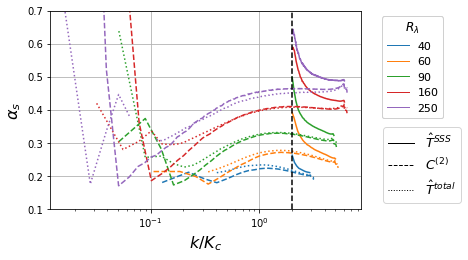

In [69]:
# results of fit
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(5,3.5))
for i in list(range(len(data_set))) :
    simu = data_set[i]
    #ik1 = simu['ikf']
    ik1 = simu['ik2f']
    indices1 = slice(ik1,simu['ik_max'])
    indices2 = np.s_[0:]
    x = simu['k']/simu['filter_cut_off_k']
    ax.plot(x[indices1], simu['t_sss']['fit_coef'][indices1,0]/((simu['L']*simu['k'][indices1])**2), '-', label=simu['Rl'], color=colors[i])
    ax.plot(x[indices2], simu['t_total']['fit_coef'][indices2,0]/((simu['L']*simu['k'][indices2])**2), ':', color=colors[i])
    ax.plot(x[indices2], simu['corr']['fit_coef'][indices2,0]/((simu['L']*simu['k'][indices2])**2), '--', color=colors[i])
#ax.annotate(r'$R_\lambda$', xy=(1.8, 1e6),  xycoords='data', xytext=(1.8, 1e3), textcoords='data', arrowprops=dict(facecolor='black', width=2), size=16,horizontalalignment='center', verticalalignment='top')
#ax.annotate(r'$k^2$', xy=(1.15, 0.6e6), xycoords='data', size='16')
ax.set(xscale='log', yscale='linear', xlabel=r'$k/K_c$',ylabel=r'$\alpha_s$'); ax.grid()
ax.set(ylim=[0.1,0.7]) 
ax.axvline(x=2, ls='--', color='k')  
legend1 = plt.legend([Line2D([0], [0], lw=1, linestyle=ls, color="black") for ls in ['-', '--', ':']], [r'$\hat{T}^{SSS}$', r'$C^{(2)}$', r'$\hat{T}^{total}$'], loc='lower left', \
                    bbox_to_anchor=(1.05, 0.0, 0.0, 1.0), fontsize=13)
# legend1 = plt.legend([Line2D([0], [0], lw=1, linestyle=ls, color="black") for ls in ['-', ':']], [r'$\hat{T}^{SSS}$', r'$C^{(2)}$'], loc='upper left', \
#                     bbox_to_anchor=(0.21, 0.0, 0.0, 1.0))
legend2 = plt.legend([Line2D([0], [0], lw=1, linestyle='-', color=ci) for ci in colors], [simu['Rl'] for simu in data_set], bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$R_\lambda$', title_fontsize=12)
ax.add_artist(legend1)
ax.add_artist(legend2)

# pp = PdfPages('/home/gorbunov8a/Documents/Latex/these/Figures/tfiltfitak2vsk.pdf')
# pp.savefig(bbox_extra_artists=(legend1,legend2), bbox_inches='tight')
# pp.close()
plt.show()

Text(0.85, 0.2, '$\\hat{T}^{SSS}$')

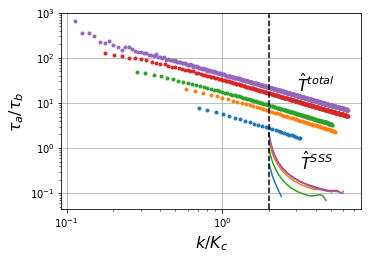

In [70]:
#degree of asymetry
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(5,3.5))
for i in list(range(len(data_set))) :
    simu = data_set[i]
    #ik1 = simu['ikf']
    ik1 = simu['ik2f']
    indices = slice(ik1,simu['ik_max']-5)
    dictionary1 = simu['t_total']
    dictionary2 = simu['t_sss']
    x = simu['k']/simu['filter_cut_off_k']
    ax.plot(x[6:], np.sqrt(dictionary1['fit_coef'][6:,1]**2.0/dictionary1['fit_coef'][6:,0]), '.')
    ax.plot(x[indices], np.sqrt(dictionary2['fit_coef'][indices,1]**2.0/dictionary2['fit_coef'][indices,0]), '-', label=simu['Rl'], color=colors[i])
#ax.annotate(r'$R_\lambda$', xy=(1.8, 1e6),  xycoords='data', xytext=(1.8, 1e3), textcoords='data', arrowprops=dict(facecolor='black', width=2), size=16,horizontalalignment='center', verticalalignment='top')
#ax.plot(simu['k'][indices]*simu['eta'], 1e1*(simu['k'][indices])**2.0, 'k--', label=r'$k^2$')
#ax.annotate(r'$k^2$', xy=(1.15, 1.6e6), xycoords='data', size='16')
ax.axvline(x=2, ls='--', color='k')     
ax.set(xscale='log', yscale='log', xlabel=r'$k/K_c$',ylabel=r'$\tau_a/\tau_b$'); ax.grid()
ax.annotate(r'$\hat{T}^{total}$', xy=(0.85, 0.6), xycoords='axes fraction', size=16, horizontalalignment='center')
ax.annotate(r'$\hat{T}^{SSS}$', xy=(0.85, 0.2), xycoords='axes fraction', size=16, horizontalalignment='center')

#lgd = ax.legend(loc='upper left', title=r'$R_\lambda$', title_fontsize=12)
# pp = PdfPages('/home/gorbunov8a/Documents/Latex/these/Figures/tfitba.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()

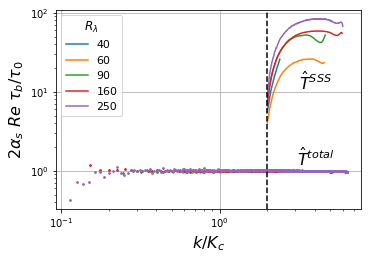

In [71]:
#degree of asymetry
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(5,3.5))
for i in list(range(len(data_set))) :
    simu = data_set[i]
    #ik1 = simu['ikf']
    ik1 = simu['ik2f']
    indices = slice(ik1,simu['ik_max']-5)
    x = simu['k']/simu['filter_cut_off_k']
    Re = simu['L']*simu['urms']/nu
    alpha = simu['corr']['fit_coef'][:,0]/((simu['L']*simu['k'][:])**2)
    yscale = 2.0*alpha*Re
    ax.plot(x[5:], 1.0/simu['t_total']['fit_coef'][5:,1]*yscale[5:], '.', ms=3.5)
    #ax.plot(x, 1.0/(2.0**Re)*Re, '--', color=colors[i])
    ax.plot(x[indices], 1.0/simu['t_sss']['fit_coef'][indices,1]*yscale[indices], '-', label=simu['Rl'], color=colors[i])
#ax.annotate(r'$R_\lambda$', xy=(1.8, 1e6),  xycoords='data', xytext=(1.8, 1e3), textcoords='data', arrowprops=dict(facecolor='black', width=2), size=16,horizontalalignment='center', verticalalignment='top')
#ax.plot(simu['k'][indices]*simu['eta'], 1e1*(simu['k'][indices])**2.0, 'k--', label=r'$k^2$')
#ax.annotate(r'$k^2$', xy=(1.15, 1.6e6), xycoords='data', size='16')
ax.set(xscale='log', yscale='log', xlabel=r'$k/K_c$',ylabel=r'$2 \alpha_s \ Re \ \tau_b/\tau_0$'); ax.grid()
ax.axvline(x=2, ls='--', color='k')     
ax.annotate(r'$\hat{T}^{SSS}$', xy=(0.85, 0.6), xycoords='axes fraction', size=16, horizontalalignment='center')
ax.annotate(r'$\hat{T}^{total}$', xy=(0.85, 0.22), xycoords='axes fraction', size=16, horizontalalignment='center')

lgd = ax.legend(loc='upper left', title=r'$R_\lambda$', title_fontsize=12)
# pp = PdfPages('/home/gorbunov8a/Documents/Latex/these/Figures/taub.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()

## Spatial spectrum

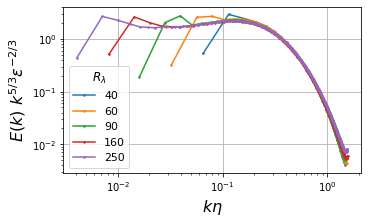

In [72]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(5,3))
#fig.suptitle(r'Compensated kinetic energy spectrum $E(k) = \frac{1}{2} C_2(t=0, k) = \frac{1}{2} \left<\hat{u}_j(t,k) \hat{u}_j^* (t,k) \right>$', size=14) 
for i in list(range(len(data_set))) :
    simu = data_set[i]
    simu['kinetic_energy'] = 0.5*simu['corr']['data'][0,::]
    indices = slice(0,simu['ik_max'])
    x = simu['k'][indices]*simu['eta']
    if (i==0) : ax.plot(x, simu['kinetic_energy'][indices]*4.0*np.pi*simu['k'][indices]**(11.0/3.0)*simu['dissip_rate']**(-2.0/3.0),\
            '.-', label=simu['Rl'], markersize=3.0)
    else :
        ax.plot(x, simu['kinetic_energy'][indices]*simu['k'][indices]**(5.0/3.0)*simu['dissip_rate']**(-2.0/3.0)*simu['spher_coef'][indices],\
            '.-', label=simu['Rl'], markersize=3.0)
    ax.set(xscale='log',yscale='log',xlabel=r'$k \eta$');
    ax.set(ylabel=r'$E(k) \ k^{5/3} \epsilon^{-2/3}$')
    ax.grid(True)
    # plot spatial scales
#     vertical_lines = 2.0*np.pi/simu['spatial_scales']*simu['k_norm']
#     for line in vertical_lines : ax.axvline(x=line)     
#     ax2 = ax.twiny(); ax2.set(xscale=ax.get_xscale(), yscale=ax.get_yscale(), xlim = ax.get_xlim())
#     ax2.set_xticks(vertical_lines); ax2.set_xticklabels([r'$2\pi/L$', r'$2\pi/\lambda$', r'$2\pi/\eta$'])
    lgd = ax.legend(loc='best', title=r'$R_\lambda$', title_fontsize=12)
# pp = PdfPages('/home/gorbunov8a/Documents/Latex/these/Figures/spectrumC2.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()

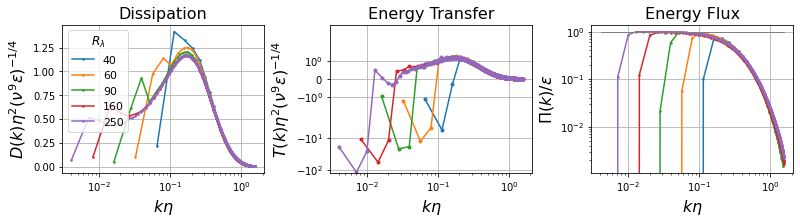

In [73]:
fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=True,figsize=(11,3))
#fig.suptitle(r'Compensated kinetic energy spectrum $E(k) = \frac{1}{2} C_2(t=0, k) = \frac{1}{2} \left<\hat{u}_j(t,k) \hat{u}_j^* (t,k) \right>$', size=14) 
nu=1e-4
for i in list(range(len(data_set))) :
    simu = data_set[i]
    simu['kinetic_energy'] = 0.5*simu['corr']['data'][0,::]
    indices = slice(0,simu['ik_max'])
    normalization=0.5*(simu['dissip_rate'])**(-0.25)*simu['eta']**2*nu**(-9/4)
    x = simu['k'][indices]*simu['eta']
    if (i==0) : ax[0].plot(x, simu['dissipation_spec'][indices]*4.0*np.pi*simu['k'][indices]**(2)*normalization,'.-', label=simu['Rl'], markersize=3.0)
    else :
        ax[0].plot(x, simu['dissipation_spec'][indices]*simu['spher_coef'][indices]*normalization, '.-', label=simu['Rl'], markersize=3.0)
    ax[2].plot(x, simu['flux_spec'][indices]/simu['dissip_rate'],'.-', label=simu['Rl'], markersize=3.0)
    ax[2].plot(x, np.full_like(x, 1.), '-', color='gray', lw=1)
    ax[1].plot(x, simu['t_total']['data'][len(data_set[i]['t_total']['time'])//2,indices]*simu['spher_coef'][indices]*normalization, '.-', label=dictionary['legend'])
ax[0].set(xscale='log',yscale='linear',xlabel=r'$k \eta$',ylabel=r'$D(k) \eta^2 (\nu^9 \epsilon)^{-1/4} $', title='Dissipation'); ax[0].grid(True)
ax[2].set(xscale='log',yscale='log',xlabel=r'$k \eta$',ylabel=r'$\Pi(k)/\epsilon$', title='Energy Flux'); ax[1].grid(True)
ax[1].set(xscale='log',yscale='symlog',xlabel=r'$k \eta$',ylabel=r'$T(k) \eta^2 (\nu^9 \epsilon)^{-1/4} $', title='Energy Transfer'); ax[2].grid(True)
lgd = ax[0].legend(loc='best', title=r'$R_\lambda$', title_fontsize=12)
# pp = PdfPages('/home/gorbunov8a/Documents/Latex/these/Figures/spectra.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()

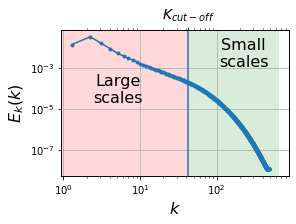

In [74]:
#spectrum
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(4,3))
#fig.suptitle(r'Total advection-velocity correlation $T_{total}(t,k) = -\Re \left< \hat{N}_j(t_0 + t, k) \hat{u}_j^* (t _0, k)\right>$', size=14) 
i=4
simu = data_set[i]
indices = slice(0,simu['ik_max'])
ax.plot(simu['k'][indices], simu['kinetic_energy'][indices]*simu['spher_coef'][indices], '.-', label='Spectrum')
ax.set(xscale='log',yscale='log',xlabel=r'$k$'); ax.grid()
ax.set(ylabel=r'$E_k(k)$')
ax.set_yticks([])
# show the range of the filtered out wavenumbers
ax.axvspan(0, simu['filter_cut_off_k']*simu['k_norm'], facecolor='red', alpha=0.15, label='Filtered out modes')
ax.axvspan(simu['filter_cut_off_k']*simu['k_norm'], ax.get_xlim()[1], facecolor='green', alpha=0.15, label='Filtered out modes')
# plot spatial scales
vertical_lines = 2.0*np.pi/simu['spatial_scales']*simu['k_norm']
ax.axvline(x=simu['filter_cut_off_k']*simu['k_norm'])     
ax2 = ax.twiny(); ax2.set(xscale=ax.get_xscale(), yscale=ax.get_yscale(), xlim = ax.get_xlim())
ax2.set_xticks([simu['filter_cut_off_k']*simu['k_norm']]); ax2.set_xticklabels([r'$K_{cut-off}$'], fontsize=14)
ax.annotate('Large\nscales', xy=(0.25, 0.5), xycoords='axes fraction', size=16, horizontalalignment='center')
ax.annotate('Small\nscales', xy=(0.8, 0.75), xycoords='axes fraction', size=16, horizontalalignment='center')
# pp = PdfPages('/home/gorbunov8a/Documents/Latex/these/Figures/filter.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()
plt.show()

# Deviation from Gaussian

In [75]:
threshold = 1e-6
for i,simu in enumerate(data_set) : 
    simu['it_cut-off'] = np.zeros_like(simu['k'], dtype=int)
    for ik, k in enumerate(simu['k']) :
        #small_amplitudes = np.argwhere(simu['corr']['data'][:,ik]/simu['corr']['data'][0,ik]<threshold)
        small_amplitudes = np.argwhere(simu['corr']['data'][:,ik]<threshold)
        if (len(small_amplitudes) > 0) :
            simu['it_cut-off'][ik] = small_amplitudes[0,0]
        else :
            simu['it_cut-off'][ik] = len(simu['corr']['time']) - 1

In [76]:
threshold_gaussian_deviation = 0.1
for i,simu in enumerate(data_set) : 
    simu['it_deviation'] = np.zeros_like(simu['k'], dtype=int)
    for ik, k in enumerate(simu['k']) :
        correlations = simu['corr']['data'][:,ik]/simu['corr']['data'][0,ik]
        x = simu['corr']['time']/simu['t0']
        gaussian = simu['corr']['fit_func'](x, *simu['corr']['fit_coef'][ik,:])
        large_deviations = np.argwhere((np.abs(correlations - gaussian)/gaussian)>threshold_gaussian_deviation)
        if (len(large_deviations) > 0) :
            simu['it_deviation'][ik] = large_deviations[0,0]
        else :
            simu['it_deviation'][ik] = len(simu['corr']['time']) - 1

/tmp/ipykernel_22998/529208430.py:8: RuntimeWarning: overflow encountered in true_divide
  large_deviations = np.argwhere((np.abs(correlations - gaussian)/gaussian)>threshold_gaussian_deviation)
/tmp/ipykernel_22998/529208430.py:8: RuntimeWarning: divide by zero encountered in true_divide
  large_deviations = np.argwhere((np.abs(correlations - gaussian)/gaussian)>threshold_gaussian_deviation)


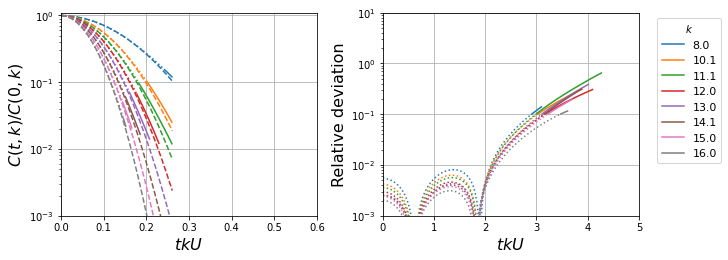

In [77]:
simu = data_set[2]

fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True,figsize=(10,3.5))
fig.suptitle=('Deviation from Gaussian')
for i,ik in enumerate(simu['indices_of_k_to_plot4'][:]) :
    scaling = simu['k'][ik]*simu['L']
    x = simu['corr']['time']/simu['t0']
    correlations = simu['corr']['data'][:,ik]/simu['corr']['data'][0,ik]
    gaussian = simu['corr']['fit_func'](x, *simu['corr']['fit_coef'][ik,:])
    
    time_sl = np.s_[0:simu['it_deviation'][ik]]
    ax[0].plot(x[time_sl], correlations[time_sl], ':', color=colors[i], label='%2.1f' % simu['k'][ik])
    ax[0].plot(x, gaussian, '--', color=colors[i], label='%2.1f' % simu['k'][ik])
    ax[1].plot(x[time_sl]*scaling, (np.abs(correlations - gaussian)/gaussian)[time_sl], ':', color=colors[i])
    
    time_sl = np.s_[simu['it_deviation'][ik]:simu['it_cut-off'][ik]]
    ax[1].plot(x[time_sl]*scaling, (np.abs(correlations - gaussian)/gaussian)[time_sl], '-', color=colors[i], label='%2.1f' % simu['k'][ik])
    ax[0].plot(x[time_sl], correlations[time_sl], '-', color=colors[i])

ax[0].set(xscale='linear',yscale='log', xlabel=r'$t k U$', ylabel=r'$C(t,k)/C(0,k)$'); ax[0].grid()
ax[1].set(xscale='linear',yscale='log', xlabel=r'$t k U$', ylabel=r'Relative deviation'); ax[1].grid()

x_max = 5.0
ax[0].set(xlim=[0,0.6])
ax[0].set(ylim=[10e-4,1.1])

ax[1].set(xlim=[0,x_max])
ax[1].set(ylim=[10e-4,10])

leg = ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$k$')

# pp = PdfPages('../Images/Scalar/vel_and_scalar_corr_Rl90_Sc07.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()
plt.show()

In [78]:
for i,simu in enumerate(data_set) : 
    data_dict = simu['corr']
    data_dict['large_time_fit'] = np.zeros([len(simu['k']),2])
    for ik, k in enumerate(simu['k']) :
        time_sl = np.s_[simu['it_deviation'][ik]:simu['it_cut-off'][ik]]
        x = data_dict['time'][time_sl]
        y = np.log(data_dict['data'][time_sl,ik])
        if (len(y) > 0) :
            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            data_dict['large_time_fit'][ik] = [slope, intercept]

/home/gorbunov8a/usr/local/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/gorbunov8a/usr/local/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/gorbunov8a/usr/local/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


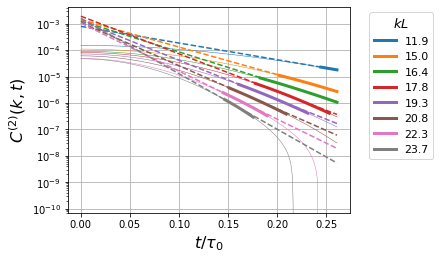

In [79]:
simu = data_set[2]

fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(6,3.5))

k_set = simu['indices_of_k_to_plot4'][:]
for i,ik in enumerate(k_set) :
    horizontal_scaling = simu['k'][ik]*simu['L']
    horizontal_scaling = 1.0
    time_sl = np.s_[simu['it_deviation'][ik]:simu['it_cut-off'][ik]+30]
    x = simu['corr']['time']/simu['t0']
    correlations = simu['corr']['data'][:,ik]
    gaussian = simu['corr']['fit_func'](x, *simu['corr']['fit_coef'][ik,:])*simu['corr']['data'][0,ik]
    
    ax.plot(x[time_sl]*horizontal_scaling, correlations[time_sl], '-', color=colors[i], label='%2.1f' % (simu['k'][ik]*simu['L']), lw=3)
    ax.plot(x*horizontal_scaling, correlations[:], color=colors[i], lw=0.5)
    ax.plot(x*horizontal_scaling, np.exp(simu['corr']['large_time_fit'][ik][0]*simu['corr']['time'] + simu['corr']['large_time_fit'][ik][1]), '--', color=colors[i])

ax.set(xscale='linear',yscale='log', xlabel=r'$t/\tau_0$', ylabel=r'$C^{(2)}(k,t)$'); ax.grid()

#x_max = simu['corr']['time'][-1]/simu['t0']
#ax.set(xlim=[0,x_max])
#ax.set(ylim=[0.5*simu['corr']['data'][time_sl,k_set[-1]][-1],10*simu['corr']['data'][time_sl,k_set[0]][0]])

leg = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$kL$', title_fontsize=13)

# pp = PdfPages('../Images/Scalar/vel_and_scalar_corr_Rl90_Sc07.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()
plt.show()

/tmp/ipykernel_22998/3036863132.py:8: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[i].set(xlabel=r'$k\etaµ$', title=r'$R_\lambda=$ %2.0i'%simu['Rl'], yscale='log', xscale='log'); ax[i].grid()
/tmp/ipykernel_22998/3036863132.py:8: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[i].set(xlabel=r'$k\etaµ$', title=r'$R_\lambda=$ %2.0i'%simu['Rl'], yscale='log', xscale='log'); ax[i].grid()


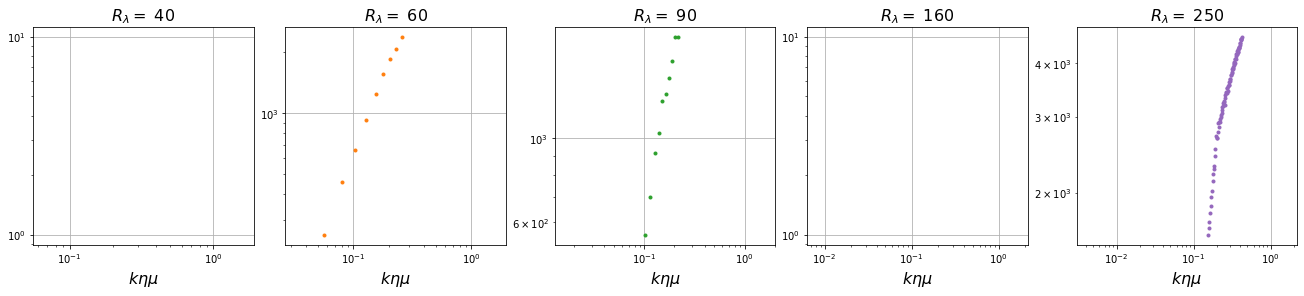

In [80]:
fig, ax = plt.subplots(nrows=1, ncols=len(data_set), constrained_layout=True,figsize=(18,4))

for i,simu in enumerate(data_set[:]) : 
    xscaling = simu['eta']
    ax[i].plot(simu['k']*xscaling, -simu['corr']['large_time_fit'][:,0]*simu['t0']**2, '.', color=colors[i], label='%2.0i' %i)
#     ax[i].plot(simu['k']*xscaling, 5e-1*simu['k']**2, '--', color='k')
#     ax[i].plot(simu['k']*xscaling, 5e1*simu['k'], '--', color='r')
    ax[i].set(xlabel=r'$k\etaµ$', title=r'$R_\lambda=$ %2.0i'%simu['Rl'], yscale='log', xscale='log'); ax[i].grid()
#     ax[i].set(xlim=[0.03,1.1])
#     ax[i].set(ylim=[15,20000])

plt.show()

In [81]:
data_set[2]['corr']['time'][-1]

9.99